<h1 style='color: blue; font-size: 34px; font-weight: bold;'> Modelo de Detecção de Fraude
</h1>
<p style='font-size: 18px; line-height: 2; margin: 0px 0px; text-align: justify; text-indent: 0px;'>    
<i> </i> 
</p>  

# <font color='orange' style='font-size: 40px;'> Library   </font>
<hr style='border: 2px solid orange;'>

In [1]:

## Bibliotecas de Análise de Dados
import pandas as pd 
import builtins as builtins
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import seaborn as sns 
from IPython.display import display, Image
from tabulate import tabulate
from matplotlib.lines import Line2D
from matplotlib.ticker import FuncFormatter

# Bibliotecas de Manipulação de Tempo
from datetime import datetime, date

## Bibliotecas de Modelagem Matemática e Estatística
import numpy as np
import scipy as sp 
import scipy.stats as stats
import statsmodels
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.stats import normaltest, ttest_ind, ttest_rel, mannwhitneyu, wilcoxon, kruskal, uniform, chi2_contingency
from statsmodels.stats.weightstats import ztest
from numpy import interp
import random

# Bibliotecas de Seleção de Modelos
from skopt import BayesSearchCV
from hyperopt import hp, tpe, fmin, Trials, STATUS_OK

# Bibliotecas de Pré-Processamento e Pipeline
from sklearn.model_selection import train_test_split, KFold, cross_val_score, cross_validate, cross_val_predict
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer

# Bibliotecas de Modelos de Machine Learning
import joblib
from joblib import Parallel, delayed
import pickle
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, IsolationForest
from lightgbm import LGBMClassifier

# Bibliotecas de Métricas de Machine Learning
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, auc, precision_score, recall_score, precision_recall_curve, average_precision_score, f1_score, log_loss, brier_score_loss, confusion_matrix, silhouette_score, make_scorer
import shap

# Parâmetros de Otimização
import random
import warnings
%matplotlib inline
sns.set(style="whitegrid", font_scale=1.2)
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = '14'
plt.rcParams['figure.figsize'] = [10, 5]
pd.set_option('display.max_rows', 100) 
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.expand_frame_repr', False)
pd.set_option('display.float_format', lambda x: '%.2f' % x) # Tira os números do formato de Notação Científica
np.set_printoptions(suppress=True) # Tira os números do formato de Notação Científica em Numpy Arrays
warnings.filterwarnings('ignore')
warnings.simplefilter(action='ignore', category=FutureWarning) # Retira Future Warnings
# from pyspark.sql import SparkSession, Row 
# from pyspark.sql.functions import *
# import pyspark.sql.functions as F
 

# # Spark Session
# spark = SparkSession.builder.getOrCreate()

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [2]:
def plota_barras(variaveis, df, titulo, rotation=0, figsize=(8,5), top_n=None):
    if isinstance(variaveis, (list, tuple)):
        if len(variaveis) == 0:
            raise ValueError("lista de variáveis vazia")
        if len(variaveis) > 1:
            for v in variaveis:
                plota_barras(v, df, f"{titulo} — {v}", rotation=rotation, figsize=figsize, top_n=top_n)
            return
        variavel = variaveis[0]
    else:
        variavel = variaveis

    counts = df[variavel].value_counts()
    if top_n is not None:
        counts = counts.head(top_n)

    order = counts.index
    values = counts.values
    total = values.sum()

    ax = sns.barplot(x=order, y=values, color='#1FB3E5')

    ax.set_title(titulo, fontsize=14)
    ax.set_xlabel(variavel, fontsize=12)
    ax.set_ylabel('Quantidade', fontsize=12)

    # Adiciona os percentuais em cima das barras
    for i, v in enumerate(values):
        ax.text(
            i,                     # posição X
            v + (max(values) * 0.01),  # posição Y (1% acima da barra)
            f'{(v/total)*100:.2f}%',  # texto
            ha='center', va='bottom', fontsize=10
        )

    ax.set_ylim(0, max(values) * 1.15)  # mais espaço pro texto
    ax.set_xticklabels(ax.get_xticklabels(), rotation=rotation, ha='right', fontsize=10)
    ax.set_yticklabels(['{:,.0f}'.format(y) for y in ax.get_yticks()], fontsize=10)

    plt.tight_layout()
    plt.show()


def plota_boxplot(df, variavel, target):
    plt.figure(figsize=(8, 5))
    sns.boxplot(x=target, y=variavel, data=df, palette=['green', 'yellow', 'red'])
    plt.title(f'Boxplot Risco de Fraude para {variavel}', fontsize=12)
    plt.xlabel(target)
    plt.ylabel(variavel)

    # Ajuste da disposição dos gráficos
    plt.tight_layout()
    plt.show()



def plota_grafico_linhas(df, x, y, nao_calcula_media, title):

    if nao_calcula_media:
        # Criando o gráfico de linha
        plt.figure(figsize=(8, 5))
        plt.plot(df[x], df[y], marker='o', linestyle='-', color='#1FB3E5')

        # Adicionando títulos e rótulos aos eixos
        plt.title(title)
        plt.xlabel(x)
        plt.ylabel(y)

        for i, txt in enumerate(df[y]):
            plt.annotate(f'{txt:.1f}', (df[x][i], df[y][i]), textcoords="offset points", xytext=(0,1), ha='center')

        # Exibindo o gráfico
        plt.grid(True)
        plt.xticks(rotation=90)
        plt.tight_layout()
        plt.show()
    else:
        media = df[y].mean()
        # Criando o gráfico de linha
        plt.figure(figsize=(10, 6))
        plt.plot(df[x], df[y], marker='o', linestyle='-', color='#1FB3E5')

        # Adicionando linha da média
        plt.axhline(y=media, color='r', linestyle='--', linewidth=1, label=f'Média: {media:.2f}')
        plt.legend()

        # Adicionando títulos e rótulos aos eixos
        plt.title(title)
        plt.xlabel(x)
        plt.ylabel(y)

        for i, txt in enumerate(df[y]):
            plt.annotate(f'{txt:.1f}', (df[x][i], df[y][i]), textcoords="offset points", xytext=(0,1), ha='center')

        # Exibindo o gráfico
        plt.grid(True)
        plt.xticks(rotation=90)
        plt.ylim(0, 20)
        plt.tight_layout()
        plt.show()

def plot_fraude(df, group_col, figsize=(18,4), cmap="RdYlGn_r"):
    # Agrupamento e cálculo
    df_group = (
        df.groupby(group_col, as_index=False)
          .agg({'transacao':'count', 'risk_transaction':'sum'})
          .rename(columns={'transacao':'qtd', 'risk_transaction':'fraude'})
    )
    df_group['%fraude'] = df_group['fraude'] / df_group['qtd'] * 100

    # Gráfico
    plt.figure(figsize=figsize)
    sns.barplot(
        data=df_group,
        x=group_col,
        y='%fraude',
        palette=cmap  # Use o nome da paleta diretamente
    )
    plt.title(f'% Fraude por {group_col.capitalize()}', fontsize=16)
    plt.xlabel(group_col.capitalize(), fontsize=12)
    plt.ylabel('% Fraude', fontsize=12)

    # Inserindo rótulos nos valores
    for index, row in df_group.iterrows():
        plt.text(
            index, 
            row['%fraude'] + 0.2, 
            f"{row['%fraude']:.1f}", 
            ha='center', 
            va='bottom', 
            fontsize=10, 
            color='black'
        )

    plt.tight_layout()
    plt.show()
    
    return df_group

In [3]:
def analisa_distribuicao_via_percentis(df, variaveis):
    def sublinha_percentis(s):
        is_1_percentile = s.name == '1%'
        is_99_8_percentile = s.name == '99%'
        if is_1_percentile or is_99_8_percentile:
            return ['background-color: blue'] * len(s)
        else:
            return [''] * len(s)

    percentis = df[variaveis].describe(percentiles = [0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.99]).style.apply(sublinha_percentis, axis=1)    

    return percentis

In [4]:
def compara_medias_amostras(df, variaveis_continuas, target="risk_transaction"):
    num_variaveis = len(variaveis_continuas)
    num_pares = (num_variaveis + 1) // 2  # Número de pares de variáveis para subplots
    fig, axes = plt.subplots(num_pares, 2, figsize=(14, 4 * num_pares))

    if num_pares == 1:
        axes = np.expand_dims(axes, axis=0)

    for i in range(num_pares):
        if 2 * i < num_variaveis:
            variavel1 = variaveis_continuas[2 * i]
            percentis1 = df[variavel1].describe(percentiles=[0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.99])
            p1_1 = percentis1['1%']
            p99_1 = percentis1['99%']
            df_raw1 = df.loc[(df[variavel1] > p1_1) & (df[variavel1] < p99_1)].copy()
            df_com_risk_transaction1 = df_raw1.loc[df_raw1[target] == 1]
            df_sem_risk_transaction1 = df_raw1.loc[df_raw1[target] == 0]

            medias_amostrais_com_risk_transaction1 = []
            medias_amostrais_sem_risk_transaction1 = []

            for j in range(5000):
                amostra_risk_transaction1 = random.choices(df_com_risk_transaction1[variavel1].values, k=1000)
                media_amostra_risk_transaction1 = np.mean(amostra_risk_transaction1)
                medias_amostrais_com_risk_transaction1.append(media_amostra_risk_transaction1)

                amostra_sem_risk_transaction1 = random.choices(df_sem_risk_transaction1[variavel1].values, k=1000)
                media_amostra_sem_risk_transaction1 = np.mean(amostra_sem_risk_transaction1)
                medias_amostrais_sem_risk_transaction1.append(media_amostra_sem_risk_transaction1)

            ax_hist1 = axes[i, 0]
            ax_hist1.hist(medias_amostrais_com_risk_transaction1, bins=30, alpha=0.5, label='risk_transaction', linewidth=5, color="red")
            ax_hist1.hist(medias_amostrais_sem_risk_transaction1, bins=30, alpha=0.5, label='Sem risk_transaction', linewidth=5, color="green")
            ax_hist1.legend(loc='upper right')
            ax_hist1.set_xlabel('Valores')
            ax_hist1.set_ylabel('Frequência')
            ax_hist1.set_title(f'Distribuição das Médias Amostrais de "{variavel1}" ')
            ax_hist1.grid(True)

        if 2 * i + 1 < num_variaveis:
            variavel2 = variaveis_continuas[2 * i + 1]
            percentis2 = df[variavel2].describe(percentiles=[0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.99])
            p1_2 = percentis2['1%']
            p99_2 = percentis2['99%']
            df_raw2 = df.loc[(df[variavel2] > p1_2) & (df[variavel2] < p99_2)].copy()
            df_com_risk_transaction2 = df_raw2.loc[df_raw2[target] == 1]
            df_sem_risk_transaction2 = df_raw2.loc[df_raw2[target] == 0]

            medias_amostrais_com_risk_transaction2 = []
            medias_amostrais_sem_risk_transaction2 = []

            for j in range(5000):
                amostra_risk_transaction2 = random.choices(df_com_risk_transaction2[variavel2].values, k=1000)
                media_amostra_risk_transaction2 = np.mean(amostra_risk_transaction2)
                medias_amostrais_com_risk_transaction2.append(media_amostra_risk_transaction2)

                amostra_sem_risk_transaction2 = random.choices(df_sem_risk_transaction2[variavel2].values, k=1000)
                media_amostra_sem_risk_transaction2 = np.mean(amostra_sem_risk_transaction2)
                medias_amostrais_sem_risk_transaction2.append(media_amostra_sem_risk_transaction2)

            ax_hist2 = axes[i, 1]
            ax_hist2.hist(medias_amostrais_com_risk_transaction2, bins=30, alpha=0.5, label='risk_transaction', linewidth=5, color="red")
            ax_hist2.hist(medias_amostrais_sem_risk_transaction2, bins=30, alpha=0.5, label='Sem risk_transaction', linewidth=5, color="green")
            ax_hist2.legend(loc='upper right')
            ax_hist2.set_xlabel('Valores')
            ax_hist2.set_ylabel('Frequência')
            ax_hist2.set_title(f'Distribuição das Médias Amostrais de "{variavel2}" ')
            ax_hist2.grid(True)
        else:
            # Remove o subplot vazio se não houver segunda variável
            fig.delaxes(axes[i, 1])

    plt.tight_layout()
    plt.show()

In [5]:
def transform_to_deciles(df, variavel_continua):
    # Calcula os limites dos deciles
    decile_limits = [i / 10 for i in range(11)]  # [0.0, 0.1, 0.2, ..., 1.0]
    
    # Aplica a função qcut para transformar a variável em deciles
    deciles = pd.qcut(df[variavel_continua], q=10, labels=False, duplicates='drop')
    
    return deciles

In [6]:
def woe(df, feature, target):

    epsilon = 1**-50  # Pequeno valor para evitar log(0)

    risk_transaction = df.loc[df[target] == 1].groupby(feature, as_index = False)[target].count().rename({target:'risk_transaction'}, axis = 1)
    sem_risk_transaction = df.loc[df[target] == 0].groupby(feature, as_index = False)[target].count().rename({target:'sem_risk_transaction'}, axis = 1)

    woe = risk_transaction.merge(sem_risk_transaction, on = feature, how = 'outer').fillna(0)
    woe['percent_risk_transaction'] = woe['risk_transaction']/woe['risk_transaction'].sum()
    woe['percent_sem_risk_transaction'] = woe['sem_risk_transaction']/woe['sem_risk_transaction'].sum()
    woe['woe'] = round(np.log((woe['percent_risk_transaction'] + epsilon)/(woe['percent_sem_risk_transaction'] + epsilon)), 3)
    woe.sort_values(by = 'woe', ascending = True, inplace = True)
    
    weight_of_evidence = woe['woe'].unique()


    x = list(woe[feature])
    y = list(woe['woe'])

    plt.figure(figsize=(10, 4))
    plt.plot(x, y, marker='o', linestyle='--', linewidth=2, color='#1FB3E5')

    for label, value in zip(x, y):
        plt.text(x=label, y=value, s=str(value), fontsize=10, color='red', ha='left', va='center', rotation=45)

    plt.title(f'Weight of Evidence da variável "{feature}"', fontsize=14)
    plt.xlabel('Classes', fontsize=14)
    plt.ylabel('Weight of Evidence', fontsize=14)
    plt.xticks(ha='right', fontsize=10, rotation=45)
    plt.show()

In [7]:
def iv(df, feature, target):
    bad = df.loc[df[target] == 1].groupby(feature, as_index = False)[target].count().rename({target:'bad'}, axis = 1)
    good = df.loc[df[target] == 0].groupby(feature, as_index = False)[target].count().rename({target:'good'}, axis = 1)
    
    woe = good.merge(bad, on = feature, how = 'outer').fillna(0)
    woe['percent_bad'] = woe['bad']/woe['bad'].sum()
    woe['percent_good'] = woe['good']/woe['good'].sum()
    woe['woe'] = round(np.log(woe['percent_bad']/woe['percent_good']), 3)
    woe.sort_values(by = 'woe', ascending = True, inplace = True)
    woe['iv'] = ((woe['percent_bad'] - woe['percent_good'])*np.log(woe['percent_bad']/woe['percent_good'])).sum()

    woe['woe'].fillna(0, inplace = True)
    woe['iv'].fillna(0, inplace = True)

    weight_of_evidence = woe['woe'].unique()
    iv = round(woe['iv'].max(), 2)

    dicionario = {feature:iv}

    iv_df = pd.DataFrame(list(dicionario.items()), columns=['Feature', 'IV'])
    
    return iv_df

In [8]:
def separa_feature_target(target, vars_drop, dados):
    x = dados.drop([target]+vars_drop, axis = 1)
    y = dados[[target]]

    return x, y

def train_min_max_scaler(df, key_cols, target):

    cols = list(df.drop(key_cols + [target], axis=1).columns)

    df_scaler = df[cols].copy()

    scaler = MinMaxScaler()
    scaler.fit(df_scaler)
    joblib.dump(scaler, "./models/scaler.pkl")
    print('Scaler Treinado e Salvo com sucesso!')

def Classificador(classificador, target, x_train, y_train, x_test, y_test, class_weight):

    # Puxa o Scaler Treinado com os dados de Treino
    scaler = joblib.load("./models/scaler.pkl")
    
    cols = list(x_train.columns)

    x_train = x_train[cols]
    x_test = x_test[cols]

    # Define as colunas categóricas e numéricas
    models = {
        'Regressão Logística': make_pipeline(
            ColumnTransformer([
                ('scaler', make_pipeline(scaler), cols)
            ]),
            LogisticRegression(
                random_state=42, # Semente aleatória para reproducibilidade dos resultados
                class_weight={0: 1, 1: class_weight}, # Peso atribuído às classes. Pode ser útil para lidar com conjuntos de dados desbalanceados.
                C=1, # Parâmetro de regularização inversa. Controla a força da regularização.
                penalty='l2', # Tipo de regularização. 'l1', 'l2', 'elasticnet', ou 'none'.
                max_iter=50, # Número máximo de iterações para a convergência do otimizador.
                solver='liblinear' # Algoritmo de otimização. 'newton-cg', 'lbfgs', 'liblinear' (gradiente descendente), 'sag' (Stochastic gradient descent), 'saga' (Stochastic gradient descent que suporta reg L1).
                )
        ),
        'LightGBM': make_pipeline(
            LGBMClassifier(
                random_state=42,             # Semente aleatória para reproducibilidade dos resultados
                n_estimators=100,             # Número de árvores no modelo
                max_depth=5,                 # Profundidade máxima
                learning_rate=0.03,          # Taxa de aprendizado
                objective='binary',          # Objetivo (classificação binária)
                class_weight={0:1, 1:class_weight},  # Pesos para classes (ou 'balanced')
                reg_alpha=5,                 # Regularização L1
                reg_lambda=5,                # Regularização L2
                min_split_gain=5,            # Controle de poda da árvore, maior gamma leva a menos crescimento da árvore
                colsample_bytree=0.5,        # Fração de features por árvore
                subsample=0.5,               # Fração de amostras por árvore
                metric='binary_logloss',     # Métrica de avaliação
                device='gpu'                 # Usa GPU (se disponível) - substitui tree_method='gpu_hist'
            )
        )
    }

    model = models[classificador]


    model.fit(x_train, y_train)
    y_pred_train = model.predict(x_train)
    y_pred_test = model.predict(x_test)

    y_proba_train = model.predict_proba(x_train)
    y_proba_test = model.predict_proba(x_test)

    return model, y_pred_train, y_pred_test, y_proba_train, y_proba_test


def otimizacao_hyperopt(x_train, y_train, x_test, y_test, max_evals, loss):

    # Espaço de busca dos hiperparâmetros
    search_space = {
        'n_estimators': hp.choice('n_estimators', [100, 150]),
        'max_depth': hp.choice('max_depth', [6, 7]),
        'learning_rate': hp.uniform('learning_rate', 0.03, 0.05),
        'reg_alpha': hp.uniform('reg_alpha', 10, 15),
        'reg_lambda': hp.uniform('reg_lambda', 10, 15),
        'min_split_gain': hp.uniform('min_split_gain', 10, 15),
        'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1),
        'subsample': hp.uniform('subsample', 0.5, 1),
        'class_weight': hp.choice('class_weight', [{0:1, 1:5},{0:1, 1:8},{0:1, 1:10},{0:1, 1:12}]),
    }

    # Função de custo para o Hyperopt

    def objective(params):
        model = LGBMClassifier(
            random_state=42,
            device='gpu',  # usar GPU aqui para acelerar
            metric='binary_logloss',
            objective='binary',
            **params
        )

        # Criar validação interna para early stopping
        X_tr, X_val, y_tr, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

        model.fit(
            X_tr, y_tr,
            eval_set=[(X_val, y_val)],
            eval_metric="auc", # usado só para early stopping
            early_stopping_rounds=3,
            verbose=False
        )

        # Essas funções que são utilizadas como função de custo para o Algoritmo de otimização
        if loss == 'auc':
            preds = model.predict_proba(X_val)[:, 1]
            score = roc_auc_score(y_val, preds)
        
        if loss == 'f1-score':
            f1_scorer = make_scorer(f1_score)  # cria o "scorer" para o cross_val_score
            score = cross_val_score(model, x_train, y_train, cv=5, scoring=f1_scorer, n_jobs=-1).mean() 
        

        return {'loss': -score, 'status': STATUS_OK}

    # Rodando a otimização
    trials = Trials()
    best = fmin(
        fn=objective, # Função de Custo do Hyperopt
        space=search_space, # Espaçom de Busca
        algo=tpe.suggest, # Algoritmo de otimização
        max_evals=max_evals, # Número máximo de avaliações
        trials=trials, # Armazena os resultados das avaliações
        rstate=np.random.default_rng(42) # Semente aleatória para reproducibilidade
    )

    # Reconstrói os hiperparâmetros escolhidos (hp.choice retorna índices)
    best['n_estimators'] = [100, 150][best['n_estimators']]
    best['max_depth'] = [6, 7][best['max_depth']] 
    best['class_weight'] = [{0:1, 1:5},{0:1, 1:8},{0:1, 1:10},{0:1, 1:12}][best['class_weight']]

    # Treina modelo final com os melhores hiperparâmetros (com early stopping também)
    best_model = LGBMClassifier(
        random_state=42,
        device='gpu',
        metric='binary_logloss',
        objective='binary',
        **best
    )

    best_model.fit(
        x_train, y_train,
        eval_set=[(x_test, y_test)],
        eval_metric="auc",
        early_stopping_rounds=3,
        verbose=False
    )

    # Organiza melhores hiperparâmetros em DataFrame
    hiperparametros = pd.DataFrame([best])

    pivot = pd.DataFrame(list(best.items())).T
    pivot.columns = pivot.iloc[0]
    melhores_hiperparametros = pivot.drop(0)
    melhores_hiperparametros['class_weight'][1][1]

    # Treina o Modelo Otimizado
    colsample_bytree = round(melhores_hiperparametros['colsample_bytree'][1], 2)
    min_split_gain = round(melhores_hiperparametros['min_split_gain'][1], 2)
    learning_rate = round(melhores_hiperparametros['learning_rate'][1], 2)
    max_depth = int(round(melhores_hiperparametros['max_depth'][1], 2))
    n_estimators = int(round(melhores_hiperparametros['n_estimators'][1], 2))
    reg_alpha = round(melhores_hiperparametros['reg_alpha'][1], 2)
    reg_lambda = round(melhores_hiperparametros['reg_lambda'][1], 2)
    class_weight = int(melhores_hiperparametros['class_weight'][1][1])
    subsample = round(melhores_hiperparametros['subsample'][1], 2)

    model = make_pipeline(
        LGBMClassifier(
            random_state=42,             # Semente aleatória para reproducibilidade dos resultados
            n_estimators=n_estimators,             # Número de árvores no modelo
            max_depth=max_depth,                 # Profundidade máxima
            learning_rate=learning_rate,          # Taxa de aprendizado
            objective='binary',          # Objetivo (classificação binária)
            class_weight= {0:1, 1:class_weight},  # Pesos para classes (ou 'balanced')
            reg_alpha=reg_alpha,                 # Regularização L1
            reg_lambda=reg_lambda,                # Regularização L2
            min_split_gain=min_split_gain,            # Controle de poda da árvore, maior gamma leva a menos crescimento da árvore
            colsample_bytree=colsample_bytree,        # Fração de features por árvore
            subsample=subsample,               # Fração de amostras por árvore
            metric='binary_logloss',     # Métrica de avaliação
            device='gpu'                 # Usa GPU (se disponível) - substitui tree_method='gpu_hist'
        )
    )

    model.fit(x_train, y_train)
    y_pred_train = model.predict(x_train)
    y_pred_test = model.predict(x_test)

    y_proba_train = model.predict_proba(x_train)
    y_proba_test = model.predict_proba(x_test)

    modelo_finalista = model

    return modelo_finalista, y_pred_train, y_pred_test, y_proba_train, y_proba_test, hiperparametros, pivot



def metricas_classificacao(classificador, y_train, y_predict_train, y_test, y_predict_test, y_predict_proba_train, y_predict_proba_test, etapa_1, etapa_2):

    predict_proba_train = pd.DataFrame(y_predict_proba_train.tolist(), columns=['predict_proba_0', 'predict_proba_1'])
    predict_proba_test = pd.DataFrame(y_predict_proba_test.tolist(), columns=['predict_proba_0', 'predict_proba_1'])

    # Treino
    accuracy_train = accuracy_score(y_train, y_predict_train)
    precision_train = precision_score(y_train, y_predict_train)
    recall_train = recall_score(y_train, y_predict_train)
    f1_train = f1_score(y_train, y_predict_train)
    roc_auc_train = roc_auc_score(y_train, predict_proba_train['predict_proba_1'])
    gini_train = 2 * roc_auc_train - 1
    fpr_train, tpr_train, thresholds_train = roc_curve(y_train, predict_proba_train['predict_proba_1'])
    ks_train = max(tpr_train - fpr_train)
    logloss_train = log_loss(y_train, predict_proba_train['predict_proba_1'])
    metricas_treino = pd.DataFrame(
        {
            'Acuracia': accuracy_train, 
            'Precisao': precision_train, 
            'Recall': recall_train, 
            'F1-Score': f1_train, 
            'Gini': gini_train,    
            'KS': ks_train, 
            'LogLoss': logloss_train,
            'Etapa': etapa_1, 
            'Classificador': classificador
        }, 
        index=[0]
    )
    
    # Teste
    accuracy_test = accuracy_score(y_test, y_predict_test)
    precision_test = precision_score(y_test, y_predict_test)
    recall_test = recall_score(y_test, y_predict_test)
    f1_test = f1_score(y_test, y_predict_test)
    roc_auc_test = roc_auc_score(y_test, predict_proba_test['predict_proba_1'])
    gini_test = 2 * roc_auc_test - 1
    fpr_test, tpr_test, thresholds_test = roc_curve(y_test, predict_proba_test['predict_proba_1'])
    ks_test = max(tpr_test - fpr_test)
    logloss_test = log_loss(y_test, predict_proba_test['predict_proba_1'])
    metricas_teste = pd.DataFrame(
        {
            'Acuracia': accuracy_test, 
            'Precisao': precision_test, 
            'Recall': recall_test, 
            'F1-Score': f1_test, 
            'Gini': gini_test, 
            'KS': ks_test, 
            'LogLoss': logloss_test,
            'Etapa': etapa_2, 
            'Classificador': classificador
        }, 
        index=[0]
    )
    
    # Consolidando
    metricas_finais = pd.concat([metricas_treino, metricas_teste])

    return metricas_finais


def metricas_classificacao_modelos_juntos(lista_modelos):
    if len(lista_modelos) > 0:
        metricas_modelos = pd.concat(lista_modelos)#.set_index('Classificador')
    else:
        metricas_modelos = lista_modelos[0]
    # Redefina o índice para torná-lo exclusivo
    df = metricas_modelos.reset_index(drop=True)
    df = df.round(2)

    # Função para formatar as células com base na Etapa
    def color_etapa(val):
        color = 'black'
        if val == 'treino':
            color = 'blue'
        elif val == 'teste':
            color = 'red'
        return f'color: {color}; font-weight: bold;'

    # Função para formatar os valores com até duas casas decimais
    def format_values(val):
        if isinstance(val, (int, float)):
            return f'{val:.2f}'
        return val

    # Estilizando o DataFrame
    styled_df = df.style\
        .format(format_values)\
        .applymap(lambda x: 'color: black; font-weight: bold; background-color: white; font-size: 14px', subset=pd.IndexSlice[:, :])\
        .applymap(color_etapa, subset=pd.IndexSlice[:, :])\
        .applymap(lambda x: 'color: black; font-weight: bold; background-color: #white; font-size: 14px', subset=pd.IndexSlice[:, 'Acuracia':'F1-Score'])\
        .applymap(lambda x: 'color: black; font-weight: bold; background-color: #white; font-size: 14px', subset=pd.IndexSlice[:, 'Etapa'])\
        .set_table_styles([
            {'selector': 'thead', 'props': [('color', 'black'), ('font-weight', 'bold'), ('background-color', 'lightgray')]}
        ])

    # Mostrando o DataFrame estilizado
    styled_df
    return styled_df

def plot_shap(model, X, titulo="SHAP Beeswarm"):
    # Pega o modelo dentro do pipeline
    model_lgbm = model.named_steps['lgbmclassifier']
    
    # Cria o objeto explainer
    explainer = shap.Explainer(model_lgbm, X)
    
    # Calcula os valores SHAP
    shap_values = explainer(X)
    
    # Cria a figura
    plt.figure(figsize=(10,6))
    shap.plots.beeswarm(shap_values, show=False)
    plt.title(titulo, fontsize=16)
    plt.grid(False)
    plt.show()

In [9]:
def calibracao_probabilidade(modelo, x_train, y_train, y_predict_proba_train, x_valid, y_valid, y_predict_proba_valid, tipo_funcao):  

    # Modelo de Calibração
    calibrated_clf = CalibratedClassifierCV(modelo, cv=5, method='isotonic')
    calibrated_clf.fit(x_train, y_train)

    y_predict_proba_ajustada_train = calibrated_clf.predict_proba(x_train)
    y_predict_proba_ajustada_valid = calibrated_clf.predict_proba(x_valid)

    predict_proba_train = pd.DataFrame(y_predict_proba_train.tolist(), columns=['predict_proba_0', 'predict_proba_1'])
    predict_proba_valid = pd.DataFrame(y_predict_proba_valid.tolist(), columns=['predict_proba_0', 'predict_proba_1'])

    predict_proba_ajustada_train = pd.DataFrame(y_predict_proba_ajustada_train.tolist(), columns=['predict_proba_0', 'predict_proba_1'])
    predict_proba_ajustada_valid = pd.DataFrame(y_predict_proba_ajustada_valid.tolist(), columns=['predict_proba_0', 'predict_proba_1'])

    # Definição das Probabilidades

    probabilities_train = predict_proba_train['predict_proba_1'] # Obtenha as probabilidades previstas
    prob_true_train, prob_pred_train = calibration_curve(y_train, probabilities_train, n_bins=10) # Calcule a curva de calibração
    brier_score_train = brier_score_loss(y_train, probabilities_train) # Calcule o Brier Score (uma métrica de calibração)

    probabilities_valid = predict_proba_valid['predict_proba_1'] # Obtenha as probabilidades previstas
    prob_true_valid, prob_pred_valid = calibration_curve(y_valid, probabilities_valid, n_bins=10) # Calcule a curva de calibração
    brier_score_valid = brier_score_loss(y_valid, probabilities_valid) # Calcule o Brier Score (uma métrica de calibração)

    probabilities_ajustada_train = predict_proba_ajustada_train['predict_proba_1'] # Obtenha as probabilidades previstas
    prob_true_ajustada_train, prob_pred_ajustada_train = calibration_curve(y_train, probabilities_ajustada_train, n_bins=10) # Calcule a curva de calibração
    brier_score_ajustada_train = brier_score_loss(y_train, probabilities_ajustada_train) # Calcule o Brier Score (uma métrica de calibração)

    probabilities_ajustada_valid = predict_proba_ajustada_valid['predict_proba_1'] # Obtenha as probabilidades previstas
    prob_true_ajustada_valid, prob_pred_ajustada_valid = calibration_curve(y_valid, probabilities_ajustada_valid, n_bins=10) # Calcule a curva de calibração
    brier_score_ajustada_valid = brier_score_loss(y_valid, probabilities_ajustada_valid) # Calcule o Brier Score (uma métrica de calibração)

    y_predict_ajustada_train_best_clf = calibrated_clf.predict(x_train)
    y_predict_ajustada_valid_best_clf = calibrated_clf.predict(x_valid)

    y_predict_proba_ajustada_train_best_clf = calibrated_clf.predict_proba(x_train)
    y_predict_proba_ajustada_valid_best_clf = calibrated_clf.predict_proba(x_valid)

    if tipo_funcao == 'plot':
        # Plote a curva de calibração
        plt.figure(figsize=(14, 5))
        plt.plot(prob_pred_train, prob_true_train, marker='o', label='Probability Curve Before Calibration- Train', color = 'blue')
        plt.plot(prob_pred_valid, prob_true_valid, marker='o', label='Probability Curve Before Calibration - valid', color = 'red')
        plt.plot(prob_pred_ajustada_train, prob_true_ajustada_train, marker='o', label='Probability Curve After Calibration - Train', color = 'green')
        plt.plot(prob_pred_ajustada_valid, prob_true_ajustada_valid, marker='o', label='Probability Curve After Calibration - valid', color = 'purple')
        plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfectly Calibrated')
        plt.title(f'Calibration Curve')
        plt.xlabel('Mean Predicted Probability')
        plt.ylabel('Fraction of Positives')
        plt.legend()
        plt.show()
    else:
        return calibrated_clf


In [10]:
def define_ponto_de_corte(df, target, key_cols, model, margem_financeira, probabilidade_churn):

    def calculate_metrics(df, target, key_cols, model, margem_financeira, probabilidade_churn):

        def retorno_financeiro(df_retorno_financeiro, margem_financeira, probabilidade_churn, y_predict):

            df_aux = df_retorno_financeiro.copy()
            df_aux['y_predict'] = y_predict
        
            df_aux['retorno_financeiro'] = (
            np.where((df_aux[target] == 0) & (df_aux['y_predict'] == 0), margem_financeira*df_aux['valor_transacao'], # Não sofre nenhuma medida, então não temos retorno nem custo
            np.where((df_aux[target] == 1) & (df_aux['y_predict'] == 0), (-1)*df_aux['valor_transacao'], # Embora não tenhamos identificado que era Fraude, não oferecemos nenhum serviço e portanto não houve custo
            np.where((df_aux[target] == 0) & (df_aux['y_predict'] == 1), (-1)*probabilidade_churn*margem_financeira*df_aux['valor_transacao'], # Implementamos a ação incorretamente, logo, estaremos fornecendo 3 meses de assinatura grátis e tendo custo
            np.where((df_aux[target] == 1) & (df_aux['y_predict'] == 1), df_aux['valor_transacao'], # Implementamos a ação corretamente, logo, estaremos retendo 50% desses casos e garantindo a assinatura deles por mais 3 meses
            0 # Não ganho nada
            )))))

            retorno_financeiro_vn = (df_aux.loc[(df_aux[target] == 0) & (df_aux['y_predict'] == 0)]['retorno_financeiro'].sum())
            retorno_financeiro_fn = (df_aux.loc[(df_aux[target] == 1) & (df_aux['y_predict'] == 0)]['retorno_financeiro'].sum())
            retorno_financeiro_fp = (df_aux.loc[(df_aux[target] == 0) & (df_aux['y_predict'] == 1)]['retorno_financeiro'].sum())
            retorno_financeiro_vp = (df_aux.loc[(df_aux[target] == 1) & (df_aux['y_predict'] == 1)]['retorno_financeiro'].sum())

            retorno_financeiro = round(retorno_financeiro_vn+retorno_financeiro_fn+retorno_financeiro_fp+retorno_financeiro_vp)


            return retorno_financeiro


        df_threshold = df.copy()

        x = separa_feature_target(target, key_cols, df)[0]
        y = separa_feature_target(target, key_cols, df)[1]

        y_pred = model.predict(x)
        y_predict_proba = model.predict_proba(x)[:, 1]

        df_threshold = df_threshold[[target, 'safra', 'valor_transacao']]
        df_threshold['Proba Fraude'] = y_predict_proba

        list_threshold = [0.05, 0.07, 0.1, 0.12, 0.15, 0.17, 0.20]
        retorno_financeiro_scores = []

        for threshold in list_threshold:
            df_threshold['y_predict_threshold'] = np.where(df_threshold['Proba Fraude'] <= threshold, 0, 1)

            retorno_financeiro_threshold= retorno_financeiro(df_threshold, margem_financeira, probabilidade_churn, df_threshold['y_predict_threshold'])
            retorno_financeiro_scores.append(retorno_financeiro_threshold)

        metrics_df = pd.DataFrame({
            'Threshold': list_threshold,
            'Retorno Financeiro': retorno_financeiro_scores
        })

        return metrics_df

    metrics = calculate_metrics(df, target, key_cols, model, margem_financeira, probabilidade_churn)
    best_threshold = metrics.loc[metrics['Retorno Financeiro'].idxmax(), 'Threshold']
    best_return = metrics['Retorno Financeiro'].max()


    sns.set(style="whitegrid", font_scale=1.2)
    plt.figure(figsize=(14, 5))

    plt.subplot(1, 1, 1)
    plt.plot(metrics['Threshold'], metrics['Retorno Financeiro'], marker='o', label='Retorno Financeiro', color='green')
    plt.annotate(f'Melhor Retorno: R${int(best_return)}', 
                xy=(best_threshold, best_return), 
                xytext=(best_threshold + 0.1, best_return + 0.1),
                arrowprops=dict(facecolor='black', shrink=0.05),
                fontsize=12,
                color='black')
    plt.title("Métricas vs Thresholds", fontsize=16)
    plt.xlabel('Threshold', fontsize=14)
    plt.ylabel('Métricas', fontsize=14)
    plt.xticks(metrics['Threshold'], rotation=45, ha='right', fontsize=12)
    plt.yticks(fontsize=12)
    plt.legend()

    plt.tight_layout()
    plt.show()

In [ ]:
def modelo_classificador_risk_transaction_oficial(df_train, df_valid, df_test, df_oot, opcao, modelo, cutoff):

    base_train = df_train.copy()
    base_valid = df_valid.copy()
    base_test = df_test.copy()
    base_oot = df_oot.copy()

    # Prepara as Amostras
    base_train['tipo_amostra'] = 'train'
    base_valid['tipo_amostra'] = 'valid'
    base_test['tipo_amostra'] = 'test'
    base_oot['tipo_amostra'] = 'oot'
    df = pd.concat([base_train, base_valid, base_test, base_oot])

    # Prepara DataFrame para Treinamento ou Escoragem
    cols = list(df.drop(['tipo_amostra', 'ano', 'safra', 'data_hora_transacao', 'valor_transacao', 'risk_transaction', 'risk_score','risk_rank', 'id_enviador', 'id_recebedor'], axis=1).columns)

    # Treina e Salva o Modelo
    if opcao == 'salvar':
        joblib.dump(modelo, "../Modelo_Deteccao_Fraude/models/classificador_risk_transaction.pkl")

        return print('Modelo de risk_transaction Treinado e Salvo com Sucesso!')

    else:
        # Carrega o Classificador e Escora para as bases de Treino, Validação, Teste e OOT
        classificador_risk_transaction = joblib.load("../Modelo_Deteccao_Fraude/models/classificador_risk_transaction.pkl")
        df_scoring = df.loc[df['tipo_amostra'].isin(['train', 'valid', 'test', 'oot'])].copy()
        df_scoring['risk_transaction_predict'] = classificador_risk_transaction.predict(df_scoring[cols])
        df_scoring['risk_transaction_predict_proba_0'] = classificador_risk_transaction.predict_proba(df_scoring[cols])[:, 0]
        df_scoring['risk_transaction_predict_proba_1'] = classificador_risk_transaction.predict_proba(df_scoring[cols])[:, 1]
        df_scoring['risk_transaction_predict'] = np.where(df_scoring['risk_transaction_predict_proba_1'] <= cutoff, 0, 1)
        df_scoring = df_scoring[['tipo_amostra', 'ano', 'safra', 'data_hora_transacao', 'valor_transacao', 'risk_score','risk_rank', 'id_enviador', 'id_recebedor','risk_transaction', 'risk_transaction_predict', 'risk_transaction_predict_proba_0', 'risk_transaction_predict_proba_1']]

        return df_scoring


In [109]:
def metricas_estabilidade_final(classificador, target, df, margem_financeira, probabilidade_churn):

    def metricas_classificacao_modelos_juntos(lista_modelos):
        if len(lista_modelos) > 0:
            metricas_modelos = pd.concat(lista_modelos)#.set_index('Classificador')
        else:
            metricas_modelos = lista_modelos[0]
        # Redefina o índice para torná-lo exclusivo
        df = metricas_modelos.reset_index(drop=True)
        df = df.round(2)

        # Função para formatar as células com base na Etapa
        def color_etapa(val):
            color = 'black'
            if val == 'treino':
                color = 'blue'
            elif val == 'teste':
                color = 'red'
            return f'color: {color}; font-weight: bold;'

        # Função para formatar os valores com até duas casas decimais
        def format_values(val):
            if isinstance(val, (int, float)):
                return f'{val:.2f}'
            return val

        # Estilizando o DataFrame
        styled_df = df.style\
            .format(format_values)\
            .applymap(lambda x: 'color: black; font-weight: bold; background-color: white; font-size: 14px', subset=pd.IndexSlice[:, :])\
            .applymap(color_etapa, subset=pd.IndexSlice[:, :])\
            .applymap(lambda x: 'color: black; font-weight: bold; background-color: #white; font-size: 14px', subset=pd.IndexSlice[:, 'Acuracia':'F1-Score'])\
            .applymap(lambda x: 'color: black; font-weight: bold; background-color: #white; font-size: 14px', subset=pd.IndexSlice[:, 'Etapa'])\
            .set_table_styles([
                {'selector': 'thead', 'props': [('color', 'black'), ('font-weight', 'bold'), ('background-color', 'lightgray')]}
            ])

        # Mostrando o DataFrame estilizado
        styled_df
        return styled_df

    def retorno_financeiro(df_retorno_financeiro, margem_financeira, probabilidade_churn, y_predict):

        df_aux = df_retorno_financeiro.copy()
        df_aux['y_predict'] = y_predict
    
        df_aux['retorno_financeiro'] = (
        np.where((df_aux[target] == 0) & (df_aux['y_predict'] == 0), margem_financeira*df_aux['valor_transacao'], # Não sofre nenhuma medida, então não temos retorno nem custo
        np.where((df_aux[target] == 1) & (df_aux['y_predict'] == 0), (-1)*df_aux['valor_transacao'], # Embora não tenhamos identificado que era Fraude, não oferecemos nenhum serviço e portanto não houve custo
        np.where((df_aux[target] == 0) & (df_aux['y_predict'] == 1), (-1)*probabilidade_churn*margem_financeira*df_aux['valor_transacao'], # Implementamos a ação incorretamente, logo, estaremos fornecendo 3 meses de assinatura grátis e tendo custo
        np.where((df_aux[target] == 1) & (df_aux['y_predict'] == 1), df_aux['valor_transacao'], # Implementamos a ação corretamente, logo, estaremos retendo 50% desses casos e garantindo a assinatura deles por mais 3 meses
        0 # Não ganho nada
        )))))

        retorno_financeiro_vn = (df_aux.loc[(df_aux[target] == 0) & (df_aux['y_predict'] == 0)]['retorno_financeiro'].sum())
        retorno_financeiro_fn = (df_aux.loc[(df_aux[target] == 1) & (df_aux['y_predict'] == 0)]['retorno_financeiro'].sum())
        retorno_financeiro_fp = (df_aux.loc[(df_aux[target] == 0) & (df_aux['y_predict'] == 1)]['retorno_financeiro'].sum())
        retorno_financeiro_vp = (df_aux.loc[(df_aux[target] == 1) & (df_aux['y_predict'] == 1)]['retorno_financeiro'].sum())

        retorno_financeiro = round(retorno_financeiro_vn+retorno_financeiro_fn+retorno_financeiro_fp+retorno_financeiro_vp)


        return retorno_financeiro

    df_estabilidade = df.copy()

    # Treino
    df_estabilidade_train = df_estabilidade.loc[~df_estabilidade['safra'].isin(['10', '11', '12'])].copy()
    accuracy_train = accuracy_score(df_estabilidade_train[target], df_estabilidade_train[f'{target}_predict'])
    precision_train = precision_score(df_estabilidade_train[target], df_estabilidade_train[f'{target}_predict'])
    recall_train = recall_score(df_estabilidade_train[target], df_estabilidade_train[f'{target}_predict'])
    f1_train = f1_score(df_estabilidade_train[target], df_estabilidade_train[f'{target}_predict'])
    roc_auc_train = roc_auc_score(df_estabilidade_train[target], df_estabilidade_train[f'{target}_predict_proba_1'])
    gini_train = 2 * roc_auc_train - 1
    fpr_train, tpr_train, thresholds_train = roc_curve(df_estabilidade_train[target], df_estabilidade_train[f'{target}_predict_proba_1'])
    ks_train = max(tpr_train - fpr_train)
    logloss_train = log_loss(df_estabilidade_train[target], df_estabilidade_train[f'{target}_predict_proba_1'])
    metricas_train = pd.DataFrame(
        {
            'Acuracia': accuracy_train, 
            'Precisao': precision_train, 
            'Recall': recall_train, 
            'F1-Score': f1_train, 
            'Gini': gini_train, 
            'KS': ks_train, 
            'LogLoss': logloss_train,
            'Etapa': 'Treino', 
            'Classificador': classificador
        }, 
        index=[0]
    )

    # Valid
    df_estabilidade_valid = df_estabilidade.loc[df_estabilidade['safra'] == '10'].copy()
    accuracy_valid = accuracy_score(df_estabilidade_valid[target], df_estabilidade_valid[f'{target}_predict'])
    precision_valid = precision_score(df_estabilidade_valid[target], df_estabilidade_valid[f'{target}_predict'])
    recall_valid = recall_score(df_estabilidade_valid[target], df_estabilidade_valid[f'{target}_predict'])
    f1_valid = f1_score(df_estabilidade_valid[target], df_estabilidade_valid[f'{target}_predict'])
    roc_auc_valid = roc_auc_score(df_estabilidade_valid[target], df_estabilidade_valid[f'{target}_predict_proba_1'])
    gini_valid = 2 * roc_auc_valid - 1
    fpr_valid, tpr_valid, thresholds_valid = roc_curve(df_estabilidade_valid[target], df_estabilidade_valid[f'{target}_predict_proba_1'])
    ks_valid = max(tpr_valid - fpr_valid)
    logloss_valid = log_loss(df_estabilidade_valid[target], df_estabilidade_valid[f'{target}_predict_proba_1'])
    metricas_valid = pd.DataFrame(
        {
            'Acuracia': accuracy_valid, 
            'Precisao': precision_valid, 
            'Recall': recall_valid, 
            'F1-Score': f1_valid, 
            'Gini': gini_valid, 
            'KS': ks_valid, 
            'LogLoss': logloss_valid,
            'Etapa': 'Validação', 
            'Classificador': classificador
        }, 
        index=[0]
    )

    # Teste
    df_estabilidade_test = df_estabilidade.loc[df_estabilidade['safra'] == '11'].copy()
    accuracy_test = accuracy_score(df_estabilidade_test[target], df_estabilidade_test[f'{target}_predict'])
    precision_test = precision_score(df_estabilidade_test[target], df_estabilidade_test[f'{target}_predict'])
    recall_test = recall_score(df_estabilidade_test[target], df_estabilidade_test[f'{target}_predict'])
    f1_test = f1_score(df_estabilidade_test[target], df_estabilidade_test[f'{target}_predict'])
    roc_auc_test = roc_auc_score(df_estabilidade_test[target], df_estabilidade_test[f'{target}_predict_proba_1'])
    gini_test = 2 * roc_auc_test - 1
    fpr_test, tpr_test, thresholds_test = roc_curve(df_estabilidade_test[target], df_estabilidade_test[f'{target}_predict_proba_1'])
    ks_test = max(tpr_test - fpr_test)
    logloss_test = log_loss(df_estabilidade_test[target], df_estabilidade_test[f'{target}_predict_proba_1'])
    metricas_test = pd.DataFrame(
        {
            'Acuracia': accuracy_test, 
            'Precisao': precision_test, 
            'Recall': recall_test, 
            'F1-Score': f1_test, 
            'Gini': gini_test, 
            'KS': ks_test, 
            'LogLoss': logloss_test,
            'Etapa': 'Teste', 
            'Classificador': classificador
        }, 
        index=[0]
    )

    # OOT
    df_estabilidade_oot = df_estabilidade.loc[df_estabilidade['safra'] == '12'].copy()
    accuracy_oot = accuracy_score(df_estabilidade_oot[target], df_estabilidade_oot[f'{target}_predict'])
    precision_oot = precision_score(df_estabilidade_oot[target], df_estabilidade_oot[f'{target}_predict'])
    recall_oot = recall_score(df_estabilidade_oot[target], df_estabilidade_oot[f'{target}_predict'])
    f1_oot = f1_score(df_estabilidade_oot[target], df_estabilidade_oot[f'{target}_predict'])
    roc_auc_oot = roc_auc_score(df_estabilidade_oot[target], df_estabilidade_oot[f'{target}_predict_proba_1'])
    gini_oot = 2 * roc_auc_oot - 1
    fpr_oot, tpr_oot, thresholds_oot = roc_curve(df_estabilidade_oot[target], df_estabilidade_oot[f'{target}_predict_proba_1'])
    ks_oot = max(tpr_oot - fpr_oot)
    logloss_oot = log_loss(df_estabilidade_oot[target], df_estabilidade_oot[f'{target}_predict_proba_1'])
    metricas_oot = pd.DataFrame(
        {
            'Acuracia': accuracy_oot, 
            'Precisao': precision_oot, 
            'Recall': recall_oot, 
            'F1-Score': f1_oot, 
            'Gini': gini_oot, 
            'KS': ks_oot, 
            'LogLoss': logloss_oot,
            'Etapa': 'Out-Of-Time', 
            'Classificador': classificador
        }, 
        index=[0]
    )
    metricas_teste_oot = metricas_classificacao_modelos_juntos([metricas_train, metricas_valid, metricas_test, metricas_oot])

    display(metricas_teste_oot)
    
    # Estabilidade
    safras = list(df_estabilidade['safra'].unique())
    metrics = {'safra': [], 'Gini': []}

    retorno_financeiro_total = 0  # Inicializa o total do retorno financeiro

    for safra in safras:
        df_safras = df.loc[df['safra'] == safra].copy()
        y_true = df_safras[f'{target}']
        y_predict = df_safras[f'{target}_predict']
        y_predict_proba_1 = df_safras[f'{target}_predict_proba_1'].values

        auc = roc_auc_score(y_true, y_predict_proba_1)
        gini = 2 * auc - 1
        fpr, tpr, _ = roc_curve(y_true, y_predict_proba_1)
        ks = max(tpr - fpr)
        precision = precision_score(y_true, y_predict)

        retorno_financeiro_calculado = retorno_financeiro(df_safras, margem_financeira, probabilidade_churn, y_predict)

        metrics['safra'].append(safra)
        metrics['Gini'].append(gini)

        retorno_financeiro_total += retorno_financeiro_calculado

    metrics_df = pd.DataFrame(metrics)

    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))

    # Gráfico das métricas
    ax1.plot(metrics_df['safra'], metrics_df['Gini'] * 100, marker='o', linestyle='-', color='blue', label='Gini')
    for i in range(len(metrics_df)):
        ax1.annotate(f'{metrics_df["Gini"].iloc[i] * 100:.2f}', 
                     (metrics_df['safra'].iloc[i], metrics_df['Gini'].iloc[i] * 100), 
                     textcoords="offset points", xytext=(0,5), ha='center', fontsize=9, color='blue')

    ax1.set_title(f'Gini por Safra ({classificador})')
    ax1.set_xlabel('Safra')
    ax1.set_ylabel('Valor')
    ax1.set_ylim(0, 100)
    ax1.legend(loc='lower right', fontsize='small')
    ax1.grid(True)
    ax1.set_xticks(metrics_df['safra'])
    ax1.set_xticklabels(metrics_df['safra'], rotation=45)

    # Gráfico do retorno financeiro total
    retorno_financeiro_total = round(retorno_financeiro_total, 0)
    ax2.text(0.5, 0.5, f'Retorno Financeiro:\nR${retorno_financeiro_total:.0f}', 
             fontsize=20, ha='center', va='center', color='black', bbox=dict(facecolor='lightgray', alpha=0.5))
    ax2.set_title('Retorno Financeiro Total')
    ax2.axis('off')

    plt.tight_layout()
    plt.show()


# <font color='orange' style='font-size: 40px;'> 1. Leitura do Dataset </font>
<hr style='border: 2px solid orange;'>

https://www.kaggle.com/datasets/faizaniftikharjanjua/metaverse-financial-transactions-dataset

# <font color='green' style='font-size: 30px;'> 1.1) Objetivos </font>
<hr style='border: 2px solid green;'>

### 1) Descrição

- Timestamp: Data e hora da transação.
- Hour of Day: Parte da hora no timestamp da transação.
- Sending Address: Endereço de blockchain do enviador.
- Receiving Address: Endereço de blockchain do recebedor.
- Amount: Valor da transação em uma moeda simulada.
- Transaction Type: Categoria da transação (por exemplo, transferência, venda, compra, golpe, phishing).
- Location Region: Região geográfica simulada da transação.
- IP Prefix: Prefixo de endereço IP simulado para a transação.
- Login Frequency: Frequência de sessões de login pelo usuário, variando por faixa etária.
- Session Duration: Duração das sessões de atividade em minutos.
- Purchase Pattern: Padrão comportamental de compras (por exemplo, focado, aleatório, de alto valor).
- Age Group: Classificação dos usuários como novos, estabelecidos e veteranos com base no histórico de atividade.
- Risk Score: Pontuação de risco calculada com base nas características da transação e no comportamento do usuário.
- Anomaly: Avaliação do nível de risco (por exemplo, alto_risco, risco_moderado, baixo_risco).

In [11]:
df_metaverse = pd.read_csv('./data/metaverse_transactions_dataset.csv')
df_metaverse = (
    df_metaverse
        .rename(
            columns=
            {
                'timestamp':'data_hora_transacao', 
                'hour_of_day':'hora_transacao', 
                'sending_address':'id_enviador', 
                'receiving_address':'id_recebedor',
                'amount':'valor_transacao', 
                'transaction_type':'tipo_transacao', 
                'location_region':'regiao_geografica', 
                'ip_prefix':'prefixo_ip',
                'login_frequency':'frequencia_login', 
                'session_duration':'duracao_sessao_atividade', 
                'purchase_pattern':'padrao_comportamental_de_compras', 
                'age_group':'recencia_atividade',
                'risk_score':'risk_score', 
                'anomaly':'risk_rank',
            }
        )
)

# Converter para datetime
df_metaverse['data_hora_transacao'] = pd.to_datetime(df_metaverse['data_hora_transacao'])
df_metaverse['ano'] = df_metaverse['data_hora_transacao'].dt.strftime('%Y')
df_metaverse['safra'] = df_metaverse['data_hora_transacao'].dt.strftime('%m')  # mês
df_metaverse['dia'] = df_metaverse['data_hora_transacao'].dt.strftime('%d')
df_metaverse['hora'] = df_metaverse['data_hora_transacao'].dt.strftime('%H')
df_metaverse['minuto'] = df_metaverse['data_hora_transacao'].dt.strftime('%M')
df_metaverse['segundo'] = df_metaverse['data_hora_transacao'].dt.strftime('%S')
df_metaverse['risk_transaction'] = np.where(df_metaverse['risk_rank'] == 'high_risk', 1, 0)
df_metaverse['transacao'] = 1
df_metaverse = (
    df_metaverse
        [[
            'ano', 'safra', 'dia', 'hora', 'minuto', 'segundo', 'data_hora_transacao', 'risk_score', 'risk_rank', 'risk_transaction', 'id_enviador','id_recebedor', 'transacao',
            'valor_transacao', 'tipo_transacao','regiao_geografica', 'prefixo_ip', 'frequencia_login',
            'duracao_sessao_atividade', 'padrao_comportamental_de_compras','recencia_atividade'
        ]]
        .sort_values(by = ['id_enviador', 'id_recebedor', 'ano', 'safra', 'dia', 'hora', 'minuto', 'segundo', 'data_hora_transacao', ], ascending = True)
)

df_metaverse.head()

,ano,safra,dia,hora,minuto,segundo,data_hora_transacao,risk_score,risk_rank,risk_transaction,id_enviador,id_recebedor,transacao,valor_transacao,tipo_transacao,regiao_geografica,prefixo_ip,frequencia_login,duracao_sessao_atividade,padrao_comportamental_de_compras,recencia_atividade
77691,2022,01,05,04,09,35,2022-01-05 04:09:35,59.06,low_risk,0,0x00262fa3b21847775e2db42965d0192e8dfe5bdc,0x757e936769ebc13de3e88f783169b547e76c1f84,1,767.45,purchase,Asia,192.17,2,27,random,new
34331,2022,01,06,12,21,50,2022-01-06 12:21:50,26.25,low_risk,0,0x00262fa3b21847775e2db42965d0192e8dfe5bdc,0x757e936769ebc13de3e88f783169b547e76c1f84,1,669.19,purchase,South America,172.00,3,64,focused,established
28911,2022,01,12,04,58,48,2022-01-12 04:58:48,20.25,low_risk,0,0x00262fa3b21847775e2db42965d0192e8dfe5bdc,0x757e936769ebc13de3e88f783169b547e76c1f84,1,295.94,transfer,Asia,172.00,4,75,focused,established
50591,2022,01,12,13,10,31,2022-01-12 13:10:31,42.00,low_risk,0,0x00262fa3b21847775e2db42965d0192e8dfe5bdc,0x757e936769ebc13de3e88f783169b547e76c1f84,1,404.26,sale,South America,192.17,2,20,random,new
42461,2022,01,20,05,32,29,2022-01-20 05:32:29,33.75,low_risk,0,0x00262fa3b21847775e2db42965d0192e8dfe5bdc,0x757e936769ebc13de3e88f783169b547e76c1f84,1,158.15,purchase,North America,10.00,3,69,focused,established


# <font color='orange' style='font-size: 40px;'> 2. Análise da Target </font>
<hr style='border: 2px solid orange;'>

# <font color='green' style='font-size: 30px;'> 2.1) Target - Risk Score, Risk Rank e Risk Clients </font>
<hr style='border: 2px solid green;'>

> 1. Temos 80% dos casos como Baixo Risco, 11% como Risco Moderado e 8% como Alto Risco

> 2. O Baixo Risco vai do Score 0 ao 60; o Risco Moderado do Score 60 ao 75 (mais ou menos) e o Alto Risco do Score 75 pra cima

> 3. A distribuição de Clientes Arriscados é relativamente estável ao longo do tempo, sem mudanças muito abruptas

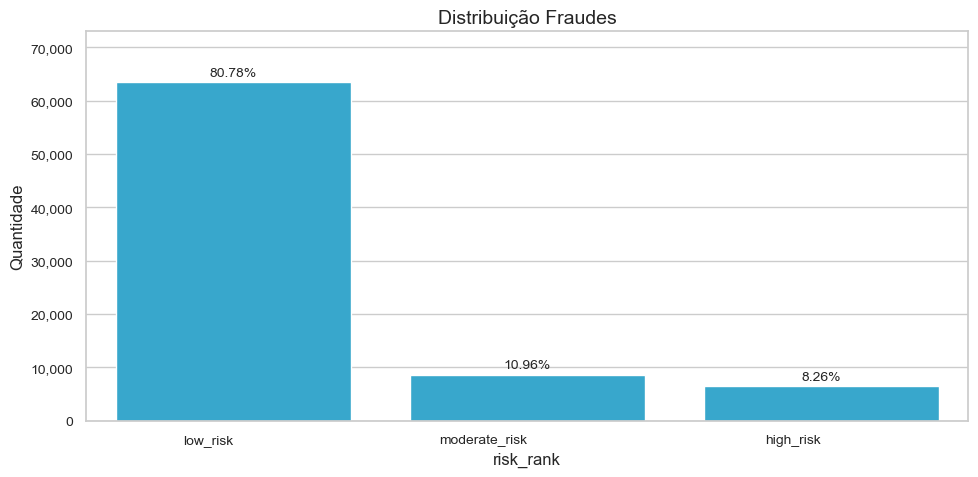

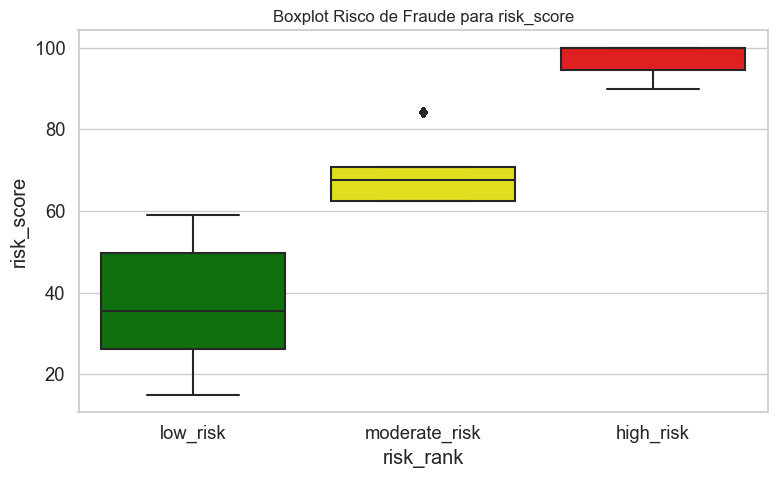

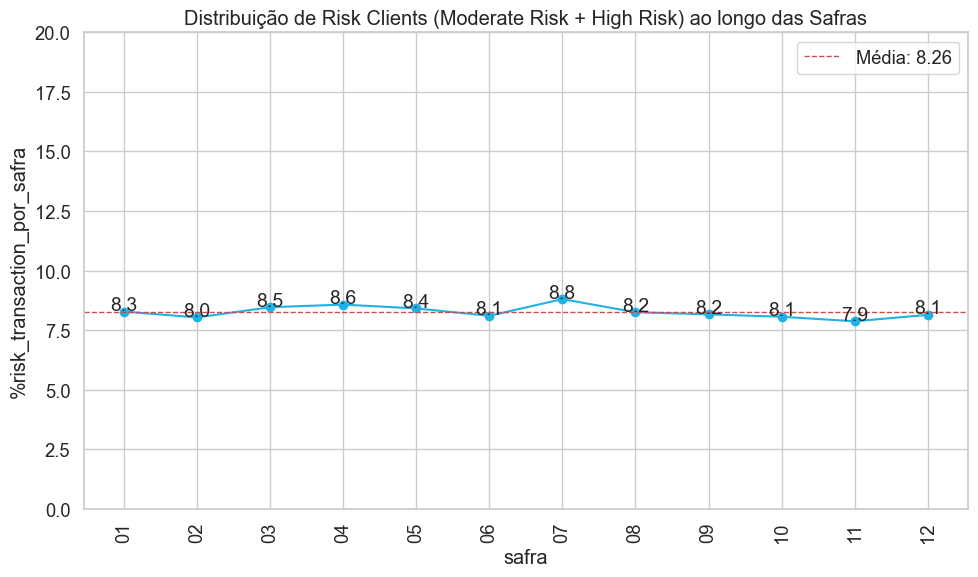

In [12]:
# Distribuição de Risk Rank
plota_barras(['risk_rank'], df_metaverse, 'Distribuição Fraudes', rotation=0)


# Risk Score vs Risk Rank
plota_boxplot(df_metaverse, 'risk_score', 'risk_rank')

# Risk Client Vs Safra
risk_transaction_por_safra = df_metaverse[["id_enviador", "safra", "risk_transaction"]].groupby("safra").agg({"risk_transaction":"sum", "id_enviador":"count"}).reset_index()
risk_transaction_por_safra["%risk_transaction_por_safra"] = round(risk_transaction_por_safra["risk_transaction"]/risk_transaction_por_safra["id_enviador"]*100, 2)
plota_grafico_linhas(risk_transaction_por_safra, "safra", "%risk_transaction_por_safra", False, "Distribuição de Risk Clients (Moderate Risk + High Risk) ao longo das Safras")

# <font color='green' style='font-size: 30px;'> 2.2) Separação de Amostras para Treino, Teste e OOT </font>
<hr style='border: 2px solid green;'>

> 1. Optou-se por definir como 1 as transações marcadas por Alto Risco e 0 como as de Moderado ou Baixo Risco

> 2. A ideia será treinar o Modelo com as safras 202201 até 202209 e testar com 202210, 202211 e 202212

- Treino + Validação --> 80% dos IDs entre 202201 e 202209, sendo 90% para Treinamento do Modelo e 10% para Validação.
- Teste --> 20% dos IDs do treino
- OOT --> Todos os IDs para 201609

-  '202201' --> TREINAMENTO
-  '202202' --> TREINAMENTO
-  '202203' --> TREINAMENTO
-  '202204' --> TREINAMENTO
-  '202205' --> TREINAMENTO
-  '202206' --> TREINAMENTO
-  '202207' --> TREINAMENTO
-  '202208' --> TREINAMENTO
-  '202209' --> TREINAMENTO
-  '202210' --> VALIDAÇÃO
-  '202211' --> TESTE
-  '202212' --> OOT (Out-Of-Time)


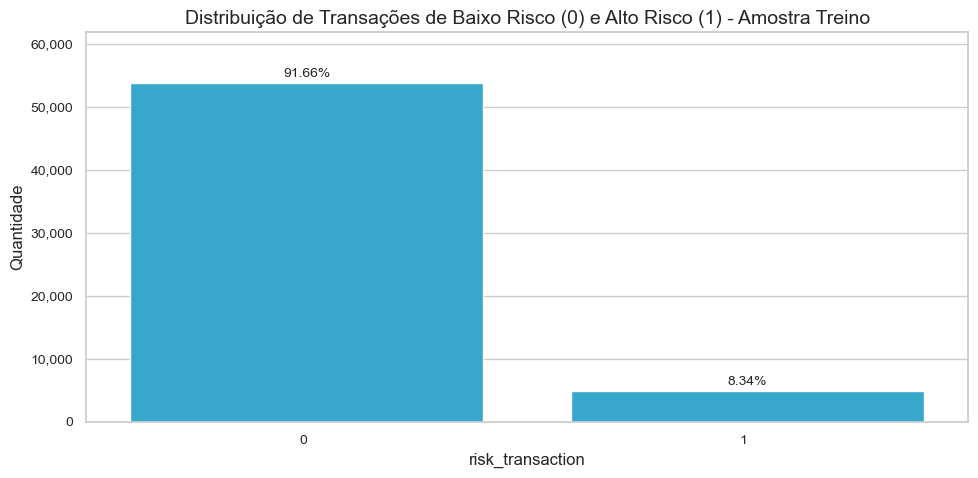

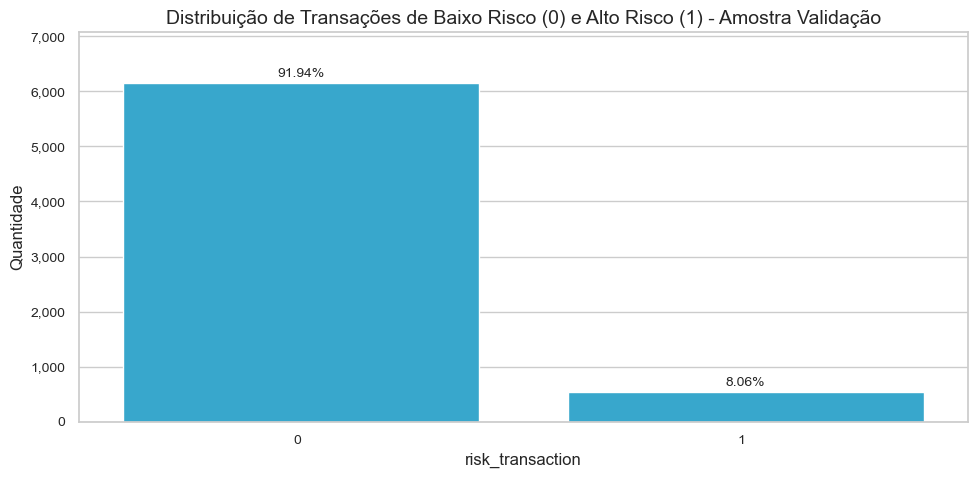

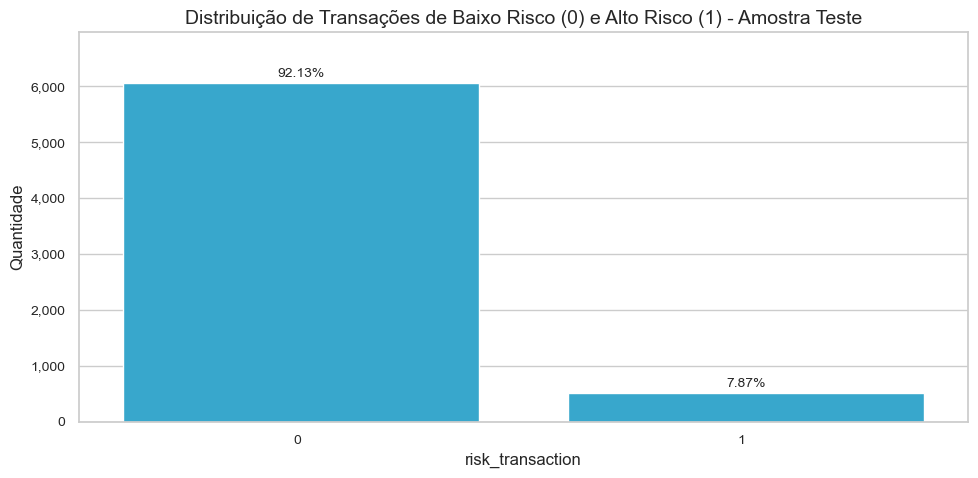

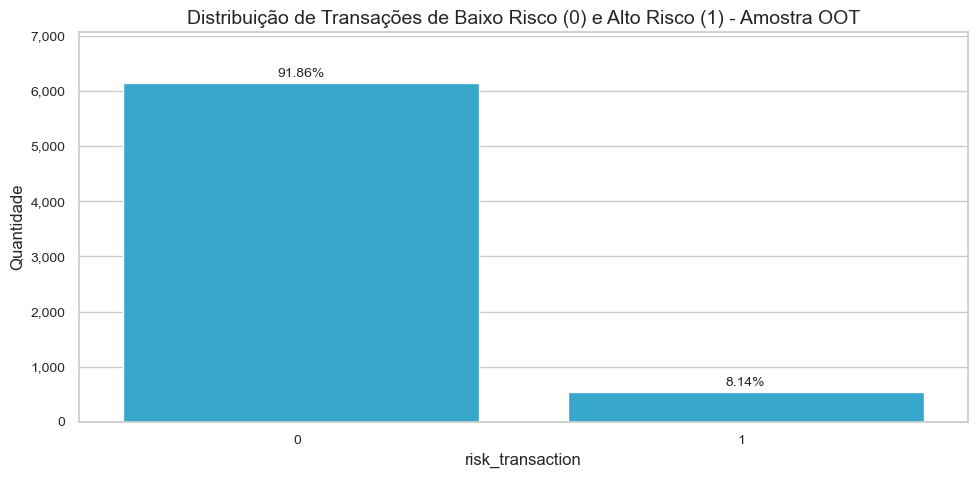

In [13]:
df_train = df_metaverse.loc[~df_metaverse["safra"].isin(["10", "11", "12"])]
df_valid = df_metaverse.loc[df_metaverse["safra"].isin(["10"])]
df_test = df_metaverse.loc[df_metaverse["safra"].isin(["11"])]
df_oot = df_metaverse.loc[df_metaverse["safra"].isin(["12"])]

amostras = [df_train, df_valid, df_test, df_oot]
tipo = ["Treino", "Validação", "Teste", "OOT"]
i = 0
for amostra in amostras:
    plota_barras(['risk_transaction'], amostra, f'Distribuição de Transações de Baixo Risco (0) e Alto Risco (1) - Amostra {tipo[i]}', 0)

    i = i + 1

# <font color='orange' style='font-size: 40px;'> 3. Análise Exploratória </font>
<hr style='border: 2px solid orange;'>

# <font color='green' style='font-size: 30px;'> 3.1) Tipo de Dados </font>
<hr style='border: 2px solid green;'>

In [14]:
target = ['risk_transaction']
key_cols = ['id_enviador', 'id_recebedor', 'risk_score', 'risk_rank']
timestamp_cols = ['ano', 'safra', 'dia', 'hora', 'minuto', 'segundo', 'data_hora_transacao']
num_cols = ['valor_transacao', 'prefixo_ip', 'frequencia_login', 'duracao_sessao_atividade']
cat_cols = ['tipo_transacao', 'regiao_geografica', 'padrao_comportamental_de_compras', 'recencia_atividade']

# <font color='green' style='font-size: 30px;'> 3.2) Nulos </font>
<hr style='border: 2px solid green;'>

Existem 21 variáveis no Dataset
Existem 21 variáveis sem registros nulos no Dataset


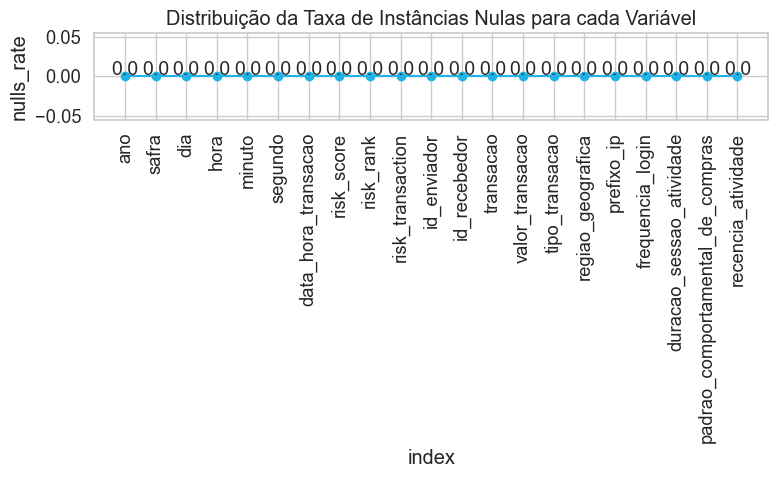

In [15]:
df_nulls = (
    pd.DataFrame(
        df_metaverse
        # .drop(["msno", "safra", "churn"] + variaveis_desconsideradas, axis = 1)
        .isnull().sum()
      )
      .reset_index()
      .rename({0:'nulls_amnt'}, axis = 1)
)
df_nulls['nulls_rate'] = round((df_nulls['nulls_amnt']/df_metaverse.shape[0])*100, 2)

print(f'Existem {len(df_nulls)} variáveis no Dataset')
df_not_nulls_nulls = df_nulls.loc[df_nulls['nulls_rate'] == 0]
columns_not_nulls = list(df_not_nulls_nulls['index'])
print(f'Existem {len(columns_not_nulls)} variáveis sem registros nulos no Dataset')

plota_grafico_linhas(df_nulls, "index", "nulls_rate", True, "Distribuição da Taxa de Instâncias Nulas para cada Variável")

# <font color='green' style='font-size: 30px;'> 3.3) Variáveis Numéricas </font>
<hr style='border: 2px solid green;'>

> 1. Não há valores muito discrepantes nas distribuições, a não ser transações de 1 centavo, o que  é estranho

> 2. Em média, tem-se a seguinte conclusão:

- As fraudes concentram-se em valores mais baixos, em operações únicas (frequências menores) e rápidas (duração mais baixa)
- O IP não aparenta discriminar a Fraude de maneira isolada

In [16]:
### Retirando amostras nulas para ver a distribuição
df_eda_continuas = df_train[num_cols].dropna().copy()
for col in df_eda_continuas[num_cols]:
    df_eda_continuas[col] = df_eda_continuas[col].apply(lambda x:float(x))

analisa_distribuicao_via_percentis(df_eda_continuas, num_cols)

,valor_transacao,prefixo_ip,frequencia_login,duracao_sessao_atividade
count,58659.000000,58659.000000,58659.000000,58659.000000
mean,502.746621,147.780349,4.173273,69.579843
std,246.283378,69.274015,2.364219,40.436642
min,0.010000,10.000000,1.000000,20.000000
1%,0.010000,10.000000,1.000000,20.000000
5%,87.412638,10.000000,1.000000,22.000000
10%,178.034576,10.000000,1.000000,25.000000
20%,288.403722,172.000000,2.000000,32.000000
30%,368.542043,172.000000,2.000000,38.000000
40%,436.513530,172.160000,3.000000,48.000000


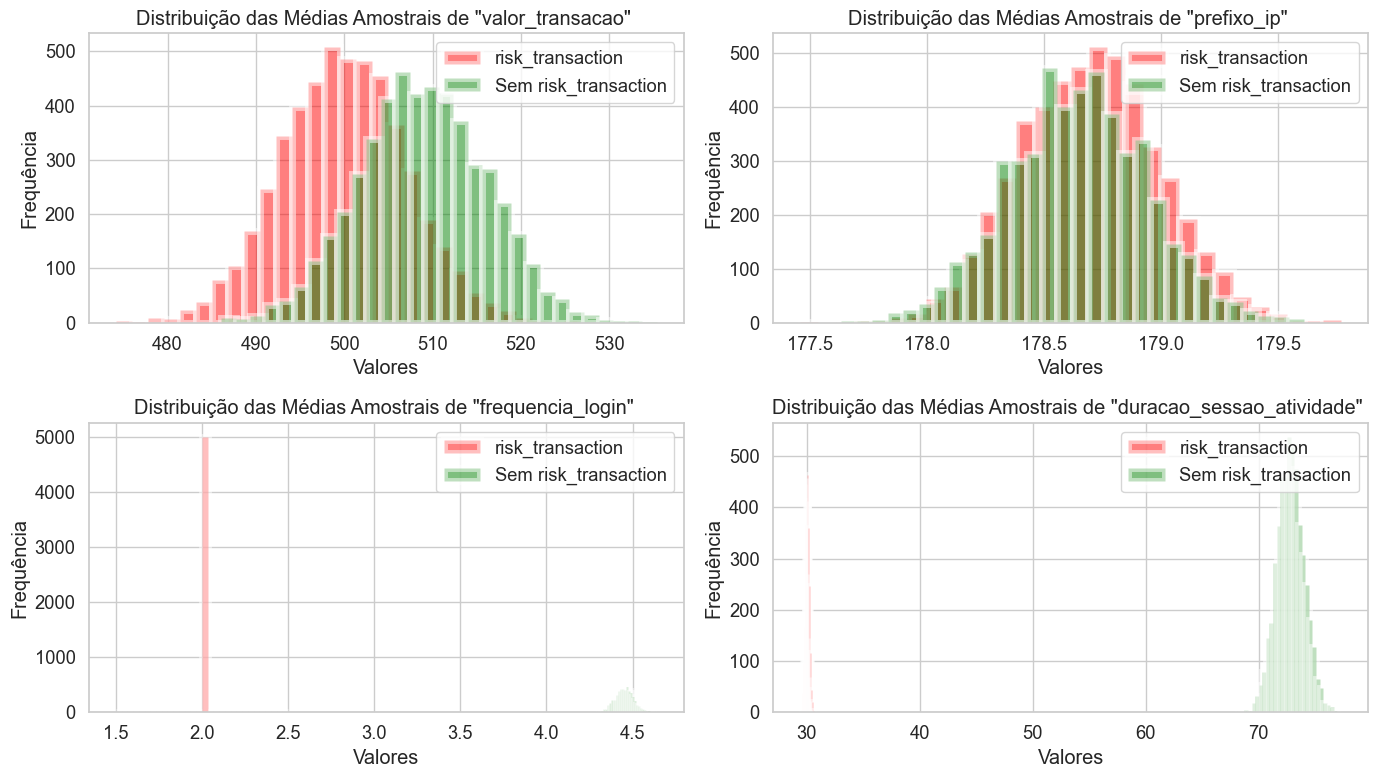

In [17]:
df_eda_continuas = df_train[num_cols + ["risk_transaction"]].dropna().copy()
for col in num_cols:
    df_eda_continuas[col] = df_eda_continuas[col].apply(lambda x: float(x))

compara_medias_amostras(df_eda_continuas, num_cols)

# <font color='green' style='font-size: 30px;'> 3.4) Variáveis Categóricas </font>
<hr style='border: 2px solid green;'>

> 1. O tipo de transação possui Data Leakage, pois só é possível saber a legitimidade de uma transação após a classificação a posteriori

> 2. A região geográfica pode ser utilizada e traz bons insights

> 3. As variáveis de padrão comportamental e recência atividade devem ser recriadas

In [18]:
df_eda_categoricas = df_train[cat_cols + ["risk_transaction"]].dropna().copy()
for col in df_eda_categoricas[cat_cols].columns:
    df_eda_categoricas[col] = df_eda_categoricas[col].apply(lambda x:str(x))
    risk_transaction = df_train.loc[df_train["risk_transaction"] == 1].groupby(col, as_index = False)["risk_transaction"].count().rename({"risk_transaction":'risk_transaction'}, axis = 1)
    sem_risk_transaction = df_train.loc[df_train["risk_transaction"] == 0].groupby(col, as_index = False)["risk_transaction"].count().rename({"risk_transaction":'sem_risk_transaction'}, axis = 1)
    distribuicao = risk_transaction.merge(sem_risk_transaction, on = col, how = 'outer').fillna(0)
    display(distribuicao)

,tipo_transacao,risk_transaction,sem_risk_transaction
0,phishing,1941.00,0.00
1,scam,2954.00,0.00
2,purchase,0.00,18554.00
3,sale,0.00,18679.00
4,transfer,0.00,16531.00


,regiao_geografica,risk_transaction,sem_risk_transaction
0,Africa,962,10612
1,Asia,997,10681
2,Europe,908,10867
3,North America,1044,10879
4,South America,984,10725


,padrao_comportamental_de_compras,risk_transaction,sem_risk_transaction
0,random,4895.00,14628
1,focused,0.00,19469
2,high_value,0.00,19667


,recencia_atividade,risk_transaction,sem_risk_transaction
0,new,4895.00,14628
1,established,0.00,19469
2,veteran,0.00,19667


# <font color='green' style='font-size: 30px;'> 3.5) Variáveis Temporais </font>
<hr style='border: 2px solid green;'>

> 1. Não há um padrão claro em termos temporais para fraude, contudo, pode-se notar pequenas observações:

- Aparentemente as fraudes crescem a partir das 13h, mais especificamente no início, meio e final do mês (onde possivelmente existem mais transações dado o comportamento econômico das pessoas)
- Não é observado um padrão mensal em fraudes, portanto, descartou-se a possibilidade de haver sazonalidade mensal


In [19]:
0.06**8

1.6796159999999995e-10

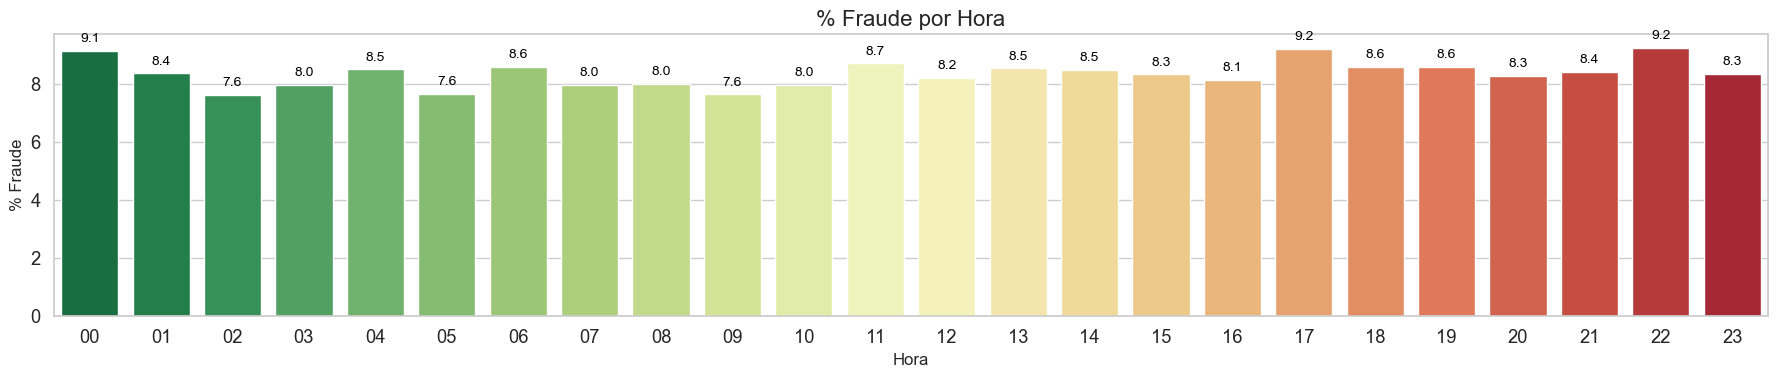

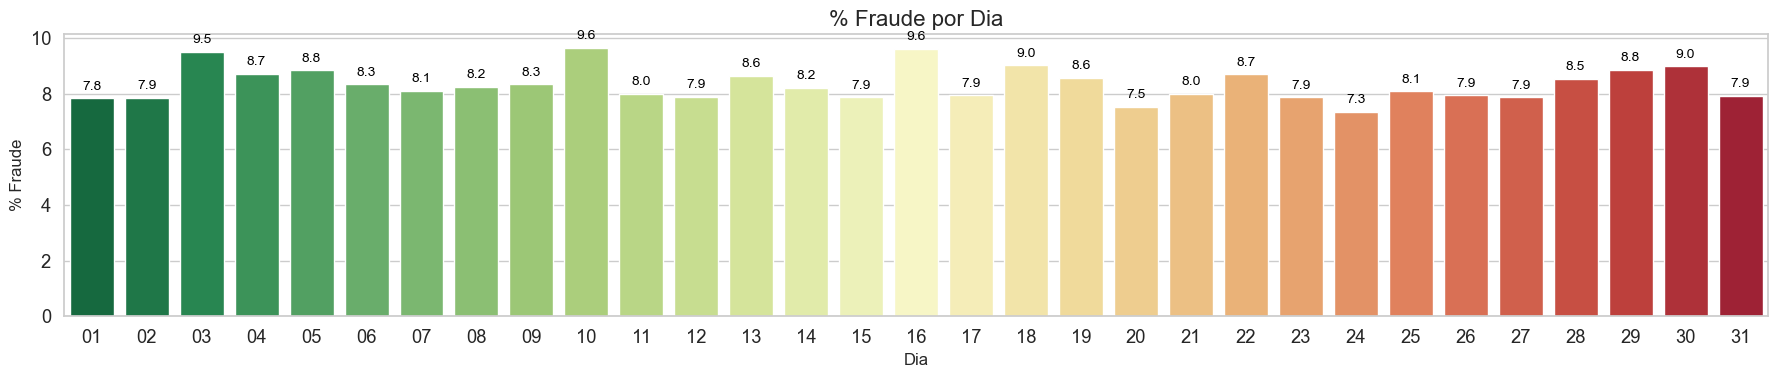

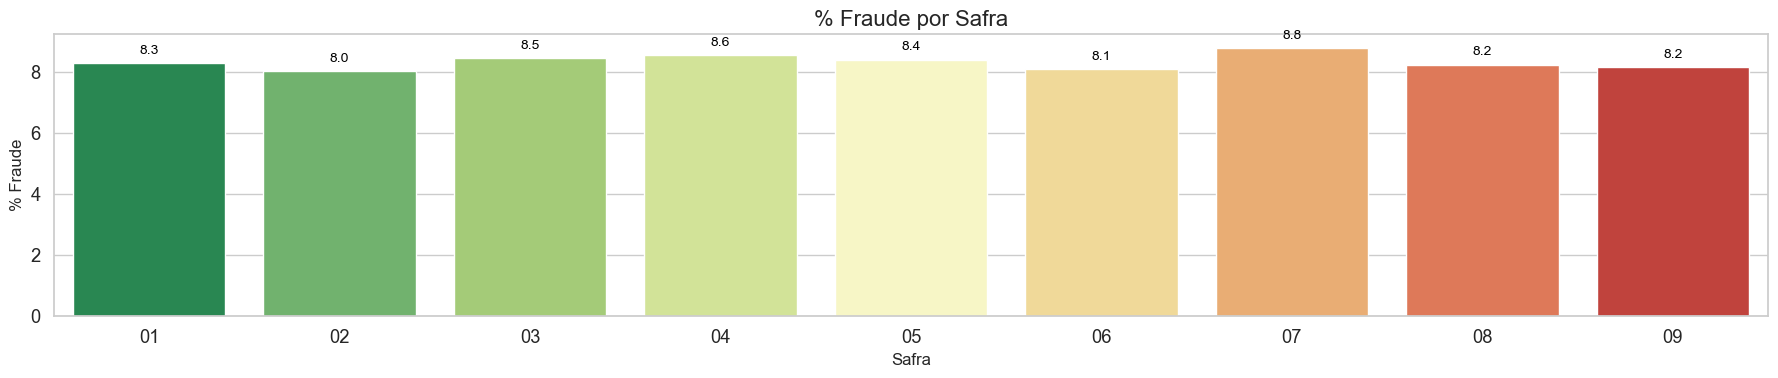

In [20]:
df_hora  = plot_fraude(df_train, "hora")
df_dia   = plot_fraude(df_train, "dia")
df_safra = plot_fraude(df_train, "safra")

# <font color='orange' style='font-size: 40px;'> 4. Feature Engineering  </font>
<hr style='border: 2px solid orange;'>

> 1. RFM

- Dias desde a última transação (dias_desde_ultima_transacao)
- Tempo entre transações consecutivas em segundos (tempo_entre_transacoes_em_segundos)
- Quantidade histórica de transações (qtd_transacoes_historico)
- Hora mais frequente de transação (hora_freq_historico)
- Dia mais frequente de transação (dia_freq_historico)
- IP mais frequente (ip_freq_historico)
- Região geográfica mais frequente (regiao_freq_historico)
- Flag de mudança de IP (mudanca_ip)
- Flag de mudança de região (mudanca_regiao) 
- Média de transações por minuto, hora e dia (media_qtd_transacoes_por_minuto/hora/dia)
- Média da duração da sessão de atividade (media_duracao_sessao_atividade)
- Valor médio, máximo, mínimo e desvio padrão das transações (media_valor_transacao_historico, max_valor_transacao_historico, min_valor_transacao_historico, std_valor_transacao_historico)
- Disparidade do valor da transação em relação à média histórica (disparidade_valor_transacao_historico)



In [21]:
def cria_features(df, tipo_relacao):
    df = df.sort_values(by=[tipo_relacao, 'data_hora_transacao']).copy()
    
    ### -------------------- Recência --------------------
    df[f'tempo_entre_transacoes_em_segundos_{tipo_relacao}'] = (
        df.groupby(tipo_relacao)['data_hora_transacao']
          .diff()
          .dt.total_seconds()
          .fillna(0)
    )

    df[f'dias_desde_ultima_transacao_{tipo_relacao}'] = (
        df.groupby(tipo_relacao)['data_hora_transacao']
          .diff()
          .dt.days
          .fillna(0)
    )

    ### -------------------- Frequência --------------------
    # Função para moda acumulada numérica
    def moda_acumulada_numerica(series):
        result = []
        for i in range(len(series)):
            if i == 0:
                result.append(-1)
            else:
                moda = series.iloc[:i].mode()
                result.append(moda.iloc[0] if not moda.empty else -1)
        return pd.Series(result, index=series.index)

    # Função para moda acumulada de strings/categóricas
    def moda_acumulada_obj(series):
        result = []
        for i in range(len(series)):
            if i == 0:
                result.append('desconhecido')
            else:
                moda = series.iloc[:i].mode()
                result.append(moda.iloc[0] if not moda.empty else 'desconhecido')
        return pd.Series(result, index=series.index)

    # Quantidade de transações históricas
    df[f'qtd_transacoes_historico_{tipo_relacao}'] = df.groupby(tipo_relacao).cumcount()

    # Hora e dia mais frequente
    df[f'hora_freq_historico_{tipo_relacao}'] = df.groupby(tipo_relacao)['hora'].apply(moda_acumulada_numerica)
    df[f'dia_freq_historico_{tipo_relacao}'] = df.groupby(tipo_relacao)['dia'].apply(moda_acumulada_numerica)

    # IP e região mais frequente
    df[f'ip_freq_historico_{tipo_relacao}'] = df.groupby(tipo_relacao)['prefixo_ip'].apply(moda_acumulada_obj)
    df[f'regiao_freq_historico_{tipo_relacao}'] = df.groupby(tipo_relacao)['regiao_geografica'].apply(moda_acumulada_obj)

    # Flags de mudança de IP e região
    df[f'mudanca_ip_{tipo_relacao}'] = (
        (df['prefixo_ip'] != df.groupby(tipo_relacao)['prefixo_ip'].shift(1)) &
        (df.groupby(tipo_relacao).cumcount() > 0)
    ).astype(int)

    df[f'mudanca_regiao_{tipo_relacao}'] = (
        (df['regiao_geografica'] != df.groupby(tipo_relacao)['regiao_geografica'].shift(1)) &
        (df.groupby(tipo_relacao).cumcount() > 0)
    ).astype(int)

    ### -------------------- Frequência granular --------------------
    def media_transacoes_por_periodo(df, periodo):
        counts = df.groupby([tipo_relacao, periodo]).size().rename(f'qtd_transacoes_{periodo}').reset_index()
        counts = counts.sort_values([tipo_relacao, periodo])
        counts[f'media_qtd_transacoes_por_{periodo}_{tipo_relacao}'] = counts.groupby(tipo_relacao)[f'qtd_transacoes_{periodo}']\
            .expanding().mean().shift(1).reset_index(level=0, drop=True).fillna(0)
        df = df.merge(
            counts[[tipo_relacao, periodo, f'media_qtd_transacoes_por_{periodo}_{tipo_relacao}']],
            on=[tipo_relacao, periodo],
            how='left'
        )
        return df

    for periodo in ['minuto', 'hora', 'dia']:
        df = media_transacoes_por_periodo(df, periodo)

    ### -------------------- Monetariedade --------------------
    def media_historica(series):
        return series.expanding().mean().shift(1).reset_index(level=0, drop=True).fillna(0)

    df[f'media_duracao_sessao_atividade_{tipo_relacao}'] = media_historica(df.groupby(tipo_relacao)['duracao_sessao_atividade'])
    df[f'media_valor_transacao_historico_{tipo_relacao}'] = media_historica(df.groupby(tipo_relacao)['valor_transacao'])
    df[f'max_valor_transacao_historico_{tipo_relacao}'] = df.groupby(tipo_relacao)['valor_transacao'].expanding().max().shift(1).reset_index(level=0, drop=True).fillna(0)
    df[f'min_valor_transacao_historico_{tipo_relacao}'] = df.groupby(tipo_relacao)['valor_transacao'].expanding().min().shift(1).reset_index(level=0, drop=True).fillna(0)
    df[f'std_valor_transacao_historico_{tipo_relacao}'] = df.groupby(tipo_relacao)['valor_transacao'].expanding().std().shift(1).reset_index(level=0, drop=True).fillna(0)

    # Disparidade protegida contra divisão por zero
    df[f'disparidade_valor_transacao_historico_{tipo_relacao}'] = (
        (df['valor_transacao'] - df[f'media_valor_transacao_historico_{tipo_relacao}']) /
        df[f'std_valor_transacao_historico_{tipo_relacao}'].replace(0, 1)
    )

    df[f'hora_freq_historico_{tipo_relacao}'] = df[f'hora_freq_historico_{tipo_relacao}'].astype(int)
    df[f'dia_freq_historico_{tipo_relacao}'] = df[f'dia_freq_historico_{tipo_relacao}'].astype(int)

    df.drop([f'regiao_freq_historico_{tipo_relacao}',f'ip_freq_historico_{tipo_relacao}'], axis = 1, inplace = True)

    return df


In [22]:
df_model = pd.concat([df_train, df_valid, df_test, df_oot])
df_model.drop(columns = ['tipo_transacao', 'padrao_comportamental_de_compras', 'recencia_atividade'], inplace=True)
df_model_features = df_model.copy()

In [23]:
df_model_features_enviador = cria_features(df_model_features, 'id_enviador')
df_model_features_recebedor = cria_features(df_model_features, 'id_recebedor')

In [24]:
df_model_final = (
    df_model_features
    .drop(columns = ['dia', 'hora', 'minuto', 'segundo','transacao', 'regiao_geografica', 'prefixo_ip'])
    .merge(
        df_model_features_enviador.drop(columns=['ano', 'safra', 'dia', 'hora', 'minuto', 'segundo',
        'risk_score', 'risk_rank', 'risk_transaction','transacao', 'valor_transacao',
        'regiao_geografica', 'prefixo_ip', 'frequencia_login',
        'duracao_sessao_atividade']),
        on=['id_enviador', 'id_recebedor', 'data_hora_transacao'],
        how='left')
    .merge(
        df_model_features_recebedor.drop(columns=['ano', 'safra', 'dia', 'hora', 'minuto', 'segundo',
        'risk_score', 'risk_rank', 'risk_transaction','transacao', 'valor_transacao',
        'regiao_geografica', 'prefixo_ip', 'frequencia_login',
        'duracao_sessao_atividade']),
        on=['id_enviador', 'id_recebedor', 'data_hora_transacao'],
        how='left')
)


# <font color='orange' style='font-size: 40px;'> 5. Modelagem  </font>
<hr style='border: 2px solid orange;'>

In [25]:
df_train = df_model_final.loc[~df_model_final["safra"].isin(["10", "11", "12"])]
df_valid = df_model_final.loc[df_model_final["safra"].isin(["10"])]
df_test = df_model_final.loc[df_model_final["safra"].isin(["11"])]
df_oot = df_model_final.loc[df_model_final["safra"].isin(["12"])]

# <font color='green' style='font-size: 30px;'> 5.1) Métricas </font>
<hr style='border: 2px solid green;'>

> 1. F1-Score

# $$ F1 = 2 \cdot \frac{\text{Precision} \cdot \text{Recall}}{\text{Precision} + \text{Recall}} $$

> 2. Gini

# $$ Gini = 2 \cdot AUC - 1 $$

> 3. KS

# $$ KS = \max |F_{\text{good}}(x) - F_{\text{bad}}(x)| $$

> 4. LogLoss 

# $$ LogLoss = -\frac{1}{N} \sum_{i=1}^{N}  y_i \cdot \log(\hat{y}_i) + (1-y_i) \cdot \log(1-\hat{y}_i) $$

> 5. Retorno Financeiro

| Situação                | Exemplo (R\$ 1.000, margem 2%, churn 10%) | Custo/Benefício |
| ----------------------- | -------------------------------------------------- | --------------- |
| VN (legítima aprovada)  | Receita da operação (2% × 1000)                    | **+20**         |
| FN (fraude aprovada)    | Reembolso integral                                 | **–1000**       |
| FP (legítima bloqueada) | Probabilidade de Churn x Receita da operação daquele cliente| **–220**        |
| VP (fraude bloqueada)   | Perda evitada (1000)                               | **+1000**       |

# $$ \begin{bmatrix} VN & FP \\ FN & VP \end{bmatrix} \begin{bmatrix} m*V & -P(Churn)*(m*V) \\ -V & +V\end{bmatrix}$$




# <font color='green' style='font-size: 30px;'> 5.2) Feature Selection + Pré-Processamento </font>
<hr style='border: 2px solid green;'>

> 1. Feature Selection
- Random Forest Feature Importance
- Correlação

> 2. Escalonamento

- Min-Max Scaler (apenas na Regressão Logística e no MLP)

> 3. Nulos

- Náo foi necessário

> 4. Conclusões:

- As features principais são a de frequencia login e duração de atividade, como já era esperado. Apenas devemos ter cuidado para contas novas, uma vez que o Falso Positivo pode ser um erro bastante presente dada essas variáveis
- As demais covariáveis também possuem importância e podem auxiliar a captar padrões complexos

In [26]:
def aplica_feature_selection(target, vars_drop, df, class_weight, threshold):
    def remove_features_feature_importance(target, vars_drop, df, class_weight, threshold):
        # Separa entre Features e Target
        x, y = separa_feature_target(target, vars_drop, df)
        
        # Criar o modelo de Random Forest
        model = RandomForestClassifier(random_state=42, criterion='entropy', n_estimators=20, class_weight={0:1, 1:class_weight})
        
        # Treinar o modelo
        model.fit(x, y)
        
        # Obter as importâncias das features
        feature_importances = model.feature_importances_
        
        # Selecionar as features com importância maior que zero
        selected_features = list(x.columns[feature_importances > threshold])
        selected_features.append(target)
        
        feature_importance_df = pd.DataFrame({
            'feature': x.columns,
            'importance': feature_importances
        }).sort_values(by='importance', ascending=False)
        feature_importance_df = feature_importance_df.loc[feature_importance_df['importance'] > 0]
        feature_importance_df['importance'] = feature_importance_df['importance'] * 100
        
        return selected_features, feature_importance_df

    def remove_features_altamente_correlacionadas(df, variaveis_importantes_df, threshold_correlacao=0.9):
        # Filtrar variáveis com alta importância
        alta_importancia_features = variaveis_importantes_df['feature'].tolist()
        
        # Selecionar as colunas do DataFrame com as variáveis de interesse
        df_reduzido = df[alta_importancia_features]
        
        # Calcular a matriz de correlação de Spearman
        correlacoes = df_reduzido.corr(method='spearman')
        
        # Encontrar variáveis altamente correlacionadas
        alta_correlacao = np.abs(correlacoes) > threshold_correlacao
        features_para_remover = set()
        
        for i in range(len(alta_correlacao.columns)):
            for j in range(i):
                if alta_correlacao.iloc[i, j] and correlacoes.columns[j] not in features_para_remover:
                    features_para_remover.add(correlacoes.columns[i])
        
        variaveis_filtradas = [col for col in alta_importancia_features if col not in features_para_remover]
        
        return variaveis_filtradas
    
    # Aplicando Random Forest e selecionado feature com importância > 0
    features, feature_importances = remove_features_feature_importance(target, vars_drop, df, class_weight, threshold)
    feature_importances = feature_importances.loc[feature_importances['importance'] > 0]
    
    # Filtrar variáveis altamente correlacionadas e mantendo a que possui maior importância com a target dentre as correlacionadas
    variaveis_selecionadas = remove_features_altamente_correlacionadas(df, feature_importances)
    feature_importances_final = feature_importances[feature_importances['feature'].isin(variaveis_selecionadas)]

    return feature_importances_final


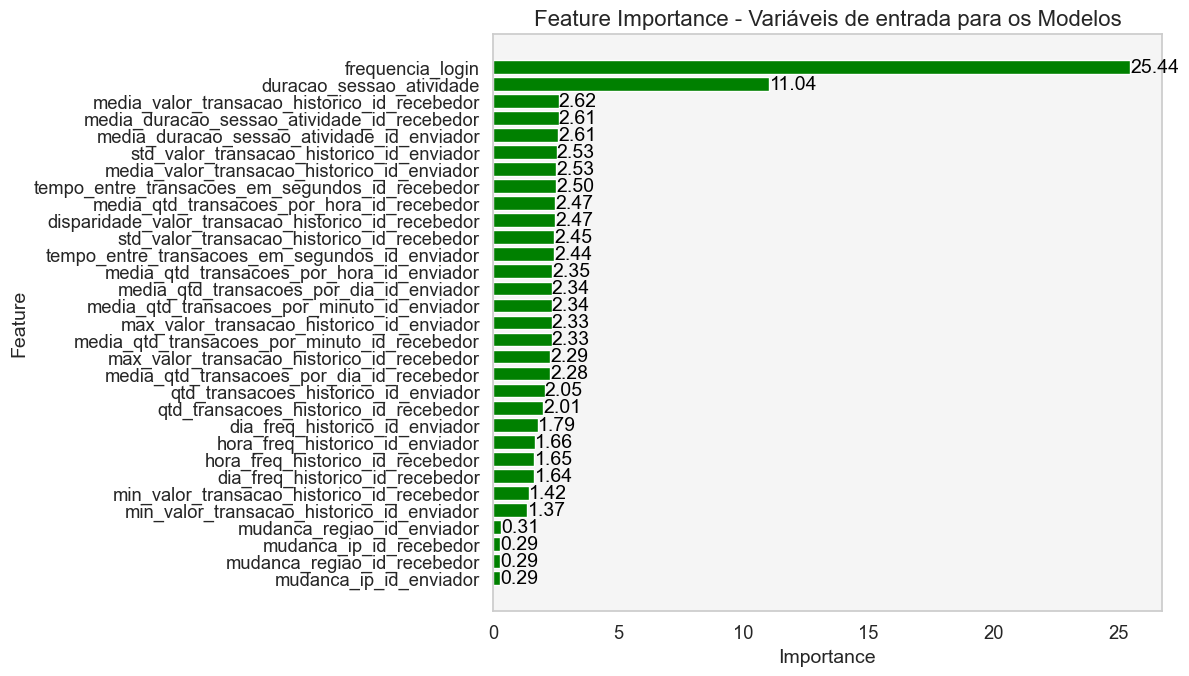

In [27]:
variaveis_finais = aplica_feature_selection('risk_transaction', ['ano', 'safra', 'data_hora_transacao', 'risk_score', 'risk_rank', 'id_enviador', 'id_recebedor'], df_train, 1, 0.9)

plt.figure(figsize=(12, 7))
sns.set(style="whitegrid", font_scale=1.2)

bars = plt.barh(variaveis_finais['feature'], variaveis_finais['importance'], color='green')
plt.title("Feature Importance - Variáveis de entrada para os Modelos", fontsize=16)
plt.xlabel('Importance', fontsize=14)
plt.ylabel('Feature', fontsize=14)

for bar in bars:
    plt.text(bar.get_width() + 0.01, bar.get_y() + bar.get_height()/2, f'{bar.get_width():.2f}', 
             va='center', ha='left', color='black', fontsize=14)


plt.tight_layout()
plt.grid(False)
plt.gca().set_facecolor('#F5F5F5')
plt.gca().invert_yaxis()
plt.show()

In [28]:
df_train = df_model_final.loc[~df_model_final["safra"].isin(["10", "11", "12"])]
df_valid = df_model_final.loc[df_model_final["safra"].isin(["10"])]
df_test = df_model_final.loc[df_model_final["safra"].isin(["11"])]
df_oot = df_model_final.loc[df_model_final["safra"].isin(["12"])]


key_cols = ['ano', 'safra', 'data_hora_transacao', 'valor_transacao', 'risk_score', 'risk_rank', 'id_enviador', 'id_recebedor']
target = 'risk_transaction'
features = list(variaveis_finais['feature'].values)
#features = [p for p in list(variaveis_finais['feature'].values) if p not in ['frequencia_login', 'duracao_sessao_atividade']]

df_train = df_train[key_cols + features + [target]].copy()
df_valid = df_valid[key_cols + features + [target]].copy()
df_test = df_test[key_cols + features + [target]].copy()
df_oot = df_oot[key_cols + features + [target]].copy()

# <font color='green' style='font-size: 30px;'> 5.3) Modelos </font>
<hr style='border: 2px solid green;'>

> 1. Modelos Testados:
- Regressão Logística
- LightGBM
- Isolation Forest

> 2. Conclusões:

- O LightGBM obteve uma performance superior à regressão logística, porém, aparenta estar um pouco overfittado

In [29]:
x_train = separa_feature_target(target, key_cols, df_train)[0]
y_train = separa_feature_target(target, key_cols, df_train)[1]

x_valid = separa_feature_target(target, key_cols, df_valid)[0]
y_valid = separa_feature_target(target, key_cols, df_valid)[1]

print(x_train.shape)
print(y_train.shape)

print(x_valid.shape)
print(y_valid.shape)

(58659, 31)
(58659, 1)
(6686, 31)
(6686, 1)


In [30]:
#Regressão Logística
reg_logistic, y_predict_train_reg_logistic, y_predict_valid_reg_logistic,  y_predict_proba_train_reg_logistic, y_predict_proba_valid_reg_logistic = Classificador( 
                                                                                                                                                    'Regressão Logística', 
                                                                                                                                                    target,
                                                                                                                                                    x_train, 
                                                                                                                                                    y_train, 
                                                                                                                                                    x_valid, 
                                                                                                                                                    y_valid, 
                                                                                                                                                    5)
metricas_reg_logistic = metricas_classificacao('Regressão Logística', y_train, y_predict_train_reg_logistic, y_valid, y_predict_valid_reg_logistic, y_predict_proba_train_reg_logistic, y_predict_proba_valid_reg_logistic, 'treino', 'validacao')
print('Rodou Regressão Logística!')
print()

# lightgbm
lightgbm, y_predict_train_lightgbm, y_predict_valid_lightgbm, y_predict_proba_train_lightgbm, y_predict_proba_valid_lightgbm = Classificador(
                                                                                                                        'LightGBM', 
                                                                                                                        target,
                                                                                                                        x_train, 
                                                                                                                        y_train, 
                                                                                                                        x_valid, 
                                                                                                                        y_valid, 
                                                                                                                        5)
metricas_lightgbm = metricas_classificacao('lightgbm', y_train, y_predict_train_lightgbm, y_valid, y_predict_valid_lightgbm, y_predict_proba_train_lightgbm, y_predict_proba_valid_lightgbm, 'treino', 'validacao')
print('Rodou lightgbm!')
print()

print('Métricas Finais')
metricas_finais = metricas_classificacao_modelos_juntos(
     [
         metricas_reg_logistic, 
         metricas_lightgbm
     ]
)
display(metricas_finais)

Rodou Regressão Logística!

Rodou lightgbm!

Métricas Finais


,Acuracia,Precisao,Recall,F1-Score,Gini,KS,LogLoss,Etapa,Classificador
0,0.79,0.25,0.77,0.38,0.73,0.73,0.30,treino,Regressão Logística
1,0.80,0.25,0.76,0.37,0.73,0.73,0.30,validacao,Regressão Logística
2,0.75,0.25,1.00,0.40,0.80,0.73,0.29,treino,lightgbm
3,0.76,0.25,0.97,0.39,0.74,0.73,0.28,validacao,lightgbm


# <font color='green' style='font-size: 30px;'> 5.4) Otimização e Explicabilidade </font>
<hr style='border: 2px solid green;'>

> 1. Metodologias:

- HyperOpt
- SHAP

> 2. Conclusões

- O HyperOpt auxiliou no combate ao Overfitting, garantindo hiperparâmetros mais seguros e que mantivessem boa performance
- O SHAP mostra a importância das variáveis e, como esperado, a frequência de login e duração da sessão de atividade foram as mais importantes. Seria interessante observar se estamos penalizando fortemente as contas novas 



In [31]:
model_otimizado, y_predict_train_otimizado, y_predict_valid_otimizado, y_proba_train_otimizado, y_proba_valid_otimizado, hiperparametros, best_hiperpams = otimizacao_hyperopt(x_train, y_train, x_valid, y_valid, 25, 'f1-score')

metricas_otimizadas_lightgbm = metricas_classificacao('HyperOpt + LightGBM', y_train, y_predict_train_otimizado, y_valid, y_predict_valid_otimizado, y_proba_train_otimizado, y_proba_valid_otimizado, 'treino', 'validacao')
print('Rodou lightgbm otimizado!')
print()

print('Métricas Finais')
metricas_finais = metricas_classificacao_modelos_juntos(
     [
         metricas_reg_logistic, 
         metricas_lightgbm,
         metricas_otimizadas_lightgbm
     ]
)

display(metricas_finais)

100%|██████████| 25/25 [00:44<00:00,  1.77s/trial, best loss: -0.40094497558193665]
Rodou lightgbm otimizado!

Métricas Finais


,Acuracia,Precisao,Recall,F1-Score,Gini,KS,LogLoss,Etapa,Classificador
0,0.79,0.25,0.77,0.38,0.73,0.73,0.30,treino,Regressão Logística
1,0.80,0.25,0.76,0.37,0.73,0.73,0.30,validacao,Regressão Logística
2,0.75,0.25,1.00,0.40,0.80,0.73,0.29,treino,lightgbm
3,0.76,0.25,0.97,0.39,0.74,0.73,0.28,validacao,lightgbm
4,0.75,0.25,1.00,0.40,0.75,0.73,0.35,treino,HyperOpt + LightGBM
5,0.75,0.25,1.00,0.39,0.73,0.73,0.35,validacao,HyperOpt + LightGBM


In [32]:
display(best_hiperpams)

,class_weight,colsample_bytree,learning_rate,max_depth,min_split_gain,n_estimators,reg_alpha,reg_lambda,subsample
0,class_weight,colsample_bytree,learning_rate,max_depth,min_split_gain,n_estimators,reg_alpha,reg_lambda,subsample
1,"{0: 1, 1: 8}",0.86,0.03,7,13.84,100,14.42,13.10,0.91


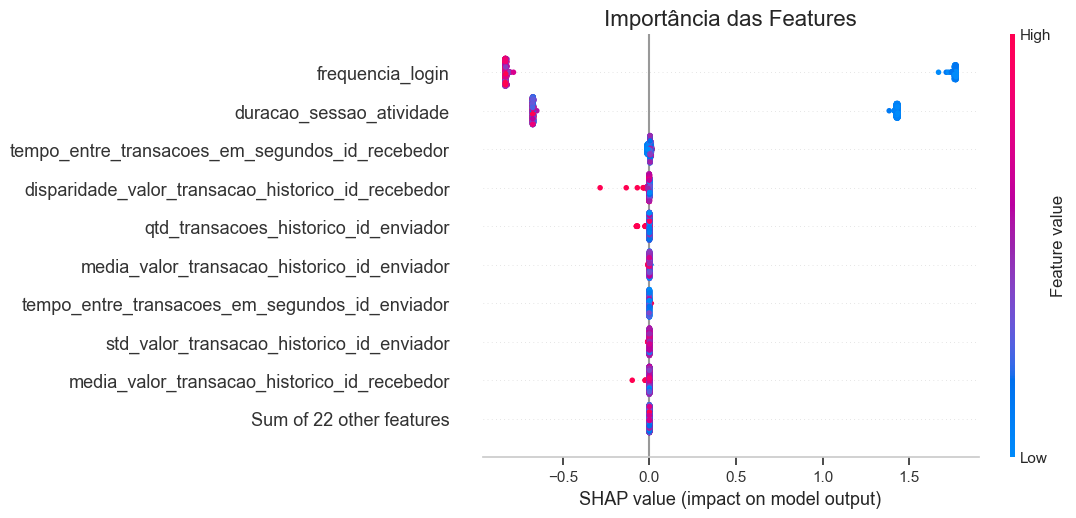

In [33]:
# Exemplo de uso
plot_shap(model_otimizado, x_train.sample(n = 1000, random_state = 42), titulo="Importância das Features")

# <font color='green' style='font-size: 30px;'> 5.5) Calibração + Threshold + Rating + Análise em Negócios</font>
<hr style='border: 2px solid green;'>

> 1. Regressão Isotônica

> 2. Curva de Retorno Financeiro

> 3. Optimal Binning 

> 4. Análise de Negócios em:

- Fraudes em contas que foram criadas apenas para isso
- Fraudes em contas legítimas

> 5. Conclusões

- A Regressão Isotônica conseguiu calibrar bem as probabiliades
- O melhor Threshold de decisão aparenta ser 0.12
- O modelo mostrou-se estável ao longo do meses
- Considerando os períodos de Treino, Validação, Teste e Out-Of-Time, o retorno financeiro estimado foi de R$ 5.5MM
- Ao final do processo, o modelo é agressivo e capta todas as fraudes, porém, ele confere como fraude transações que não são fraudulentas
- Ainda sim, o retorno financeiro afirma que essa decisão faz sentido

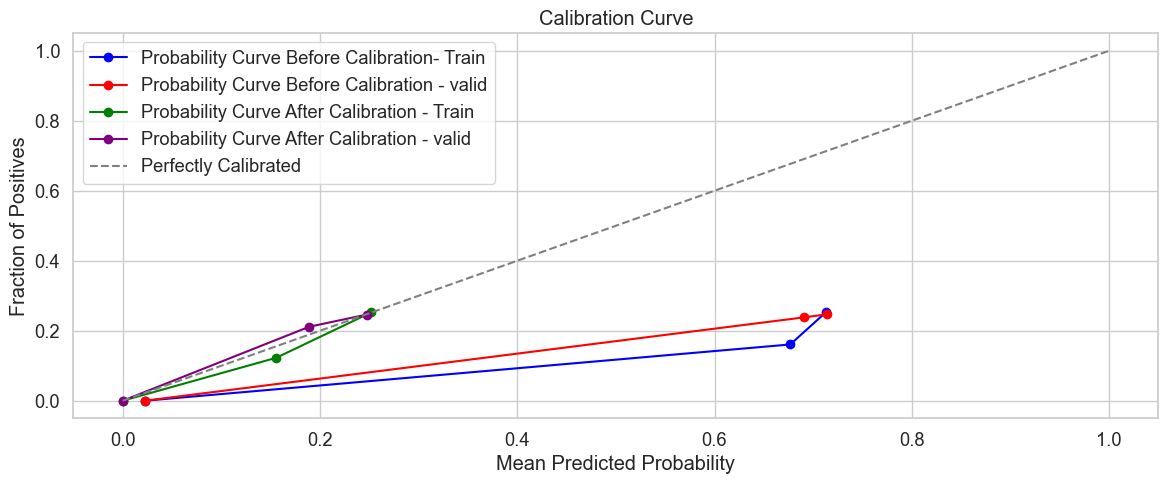

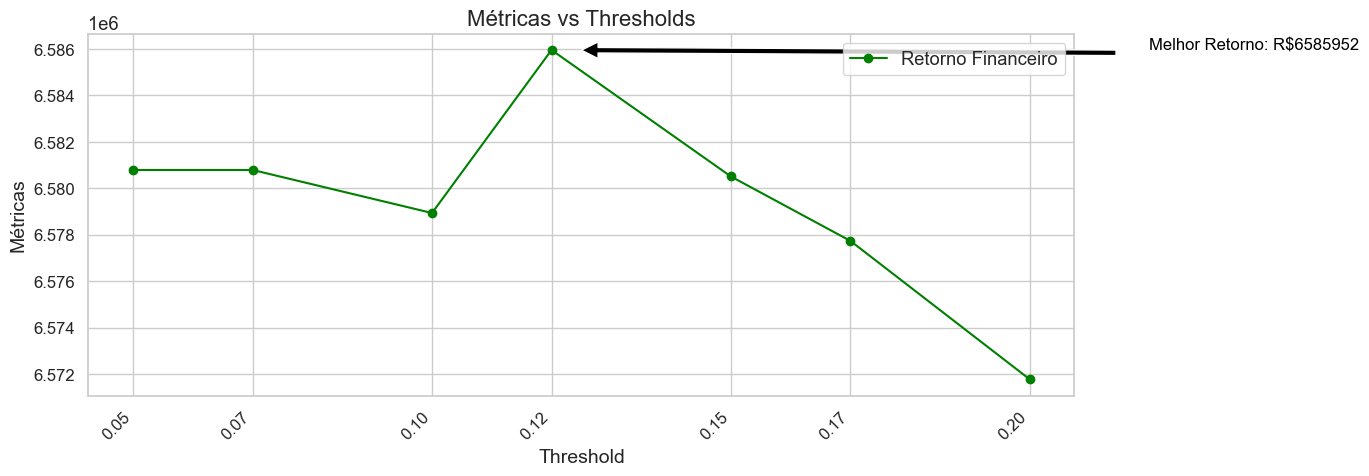

Modelo de risk_transaction Treinado e Salvo com Sucesso!


,Acuracia,Precisao,Recall,F1-Score,Gini,KS,LogLoss,Etapa,Classificador
0,0.75,0.25,1.00,0.40,0.75,0.73,0.19,Treino,HyperOpt + LightGBM + Regressão Isotônica + Cut-Off de Probabilidade
1,0.75,0.25,1.00,0.39,0.73,0.73,0.18,Validação,HyperOpt + LightGBM + Regressão Isotônica + Cut-Off de Probabilidade
2,0.75,0.24,1.00,0.38,0.72,0.73,0.18,Teste,HyperOpt + LightGBM + Regressão Isotônica + Cut-Off de Probabilidade
3,0.74,0.24,1.00,0.39,0.73,0.72,0.19,Out-Of-Time,HyperOpt + LightGBM + Regressão Isotônica + Cut-Off de Probabilidade


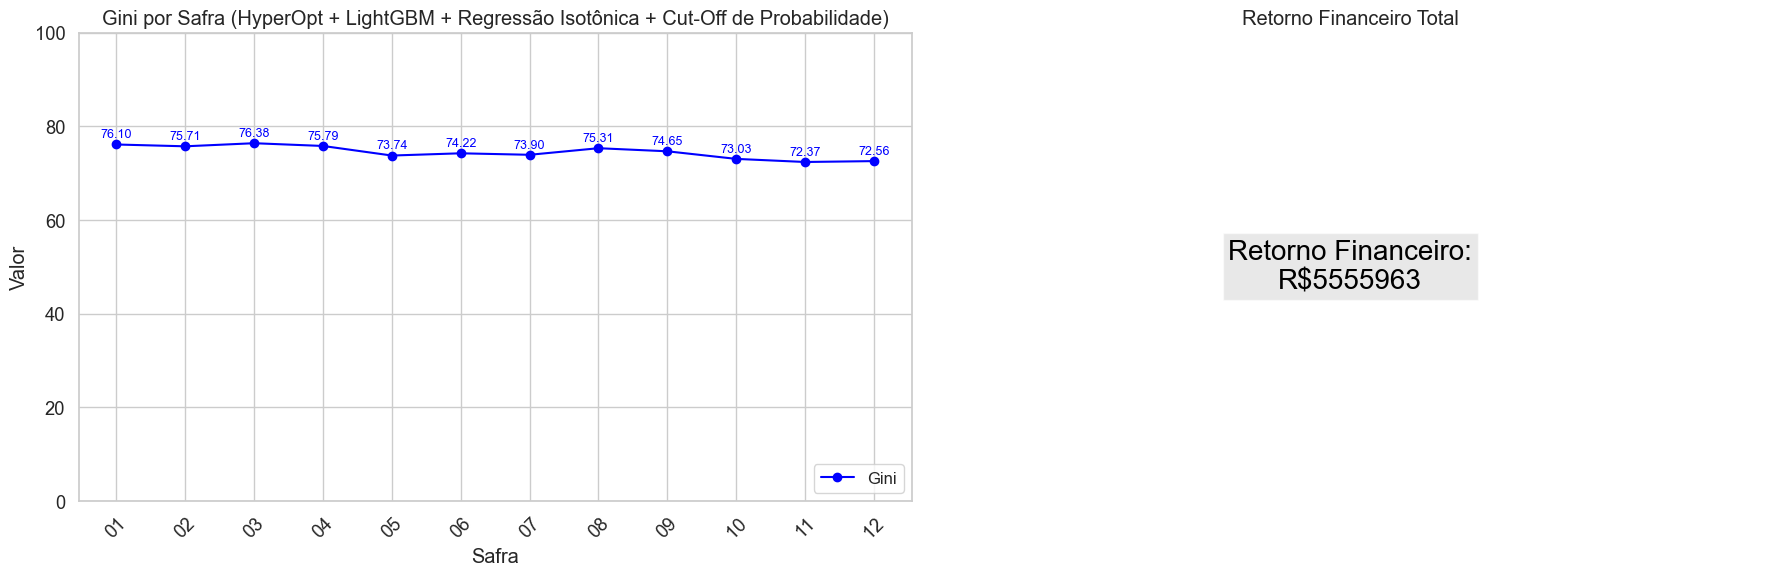

In [115]:
########## Calibração de Probabilidades ##########
calibracao_probabilidade(model_otimizado.named_steps['lgbmclassifier'], x_train, y_train, y_proba_train_otimizado, x_valid, y_valid, y_proba_valid_otimizado, 'plot')
modelo_otimizado_calibrado = calibracao_probabilidade(model_otimizado.named_steps['lgbmclassifier'], x_train, y_train, y_proba_train_otimizado, x_valid, y_valid, y_proba_valid_otimizado, 'predict')

########### Definição do Ponto de Corte ##########
define_ponto_de_corte(pd.concat([df_train, df_valid]), 'risk_transaction', key_cols, modelo_otimizado_calibrado, 0.20, 0.30)

########### Análise Final ##########
modelo_classificador_risk_transaction_oficial(df_train, df_valid, df_test, df_oot, 'salvar', modelo_otimizado_calibrado, 0.12)
df_analise_final = modelo_classificador_risk_transaction_oficial(df_train, df_valid, df_test, df_oot, 'escoragem', modelo_otimizado_calibrado, 0.12)
metricas_estabilidade_final('HyperOpt + LightGBM + Regressão Isotônica + Cut-Off de Probabilidade', 'risk_transaction', df_analise_final, 0.10, 0.30)